In [1]:
import nest_asyncio
import stan
import numpy as np
import pandas as pd
import os
from os import path
import glob
from RLmodels import QLearningModel
# from RLmodels import qLearningModel_5params_simNoPlot
from RLmodels import RestlessBanditDecoupled
from RLmodels import QLearningModelSim, myPairPlot, getSessionFitParams
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import re
from scipy.stats import norm
from scipy.stats import halfcauchy
from scipy.stats import cauchy
from sklearn.linear_model import LinearRegression
import pickle
import json
nest_asyncio.apply()
from aind_dynamic_foraging_basic_analysis.lick_analysis import plot_lick_analysis, load_data, load_nwb, cal_metrics, plot_met
from aind_dynamic_foraging_basic_analysis import plot_foraging_session
from beh_utils import*
import statsmodels.api as sm
import json

In [2]:
# load sessions
# get list of available sessions
file_pattern = "*.nwb"
nwb_folder = "/root/capsule/data/foraging_nwb_bonsai"
file_list = glob.glob(os.path.join(nwb_folder + "/" + file_pattern))
file_names = [os.path.basename(file) for file in file_list]
# file_name = file_names[20]
    
results = [parseSessionID(file_name) for file_name in file_names]
aniIDs, dates = zip(*results)

sessionInfo = pd.DataFrame({'sessionID': file_names,
                            'aniID': aniIDs,
                            'date': dates})

In [3]:
reference_date = datetime(2024, 5, 15)
animalID = '717121'
targetInds = np.where((sessionInfo['date'] >= reference_date) & (sessionInfo['aniID'] == animalID))[0]

/opt/conda/lib/python3.10/site-packages/aind_dynamic_foraging_basic_analysis/lick_analysis.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15, 8))
/opt/conda/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/conda/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/conda/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected

Dictionary has been saved to /root/capsule/scratch/717121/717121_session_data.csv


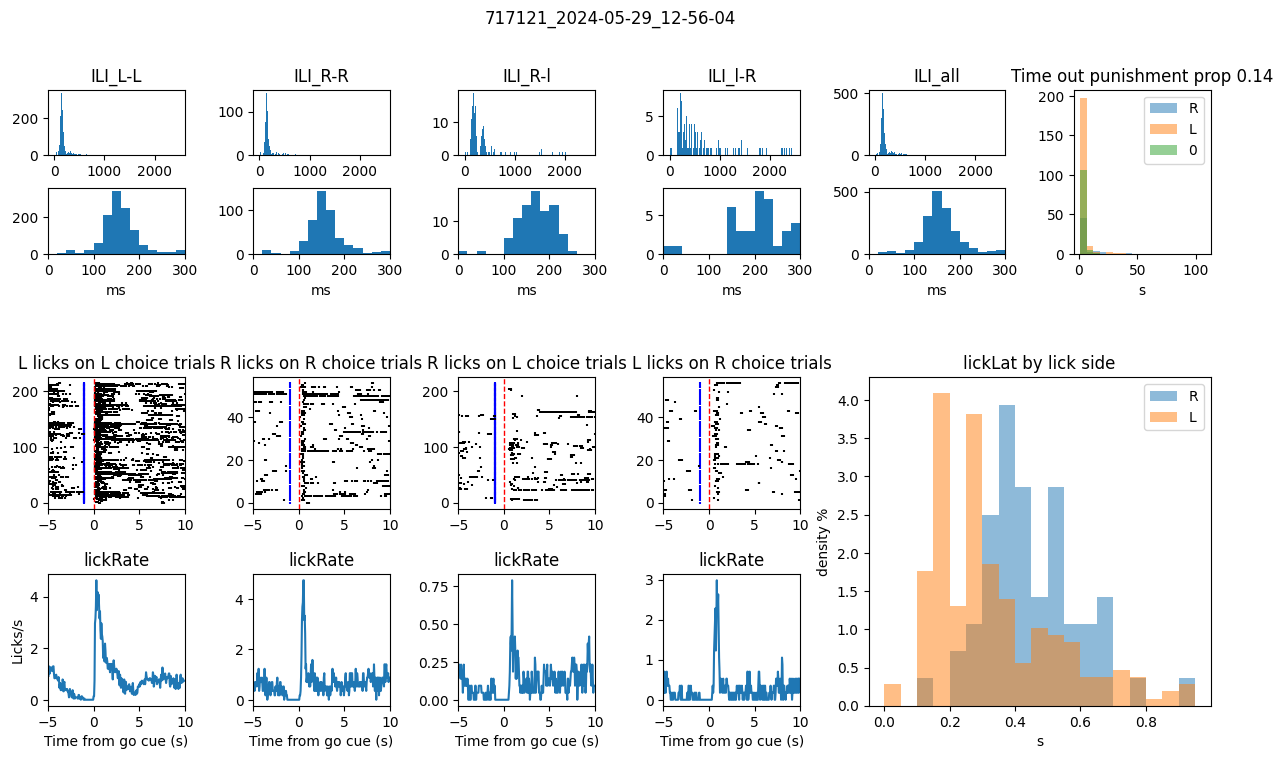

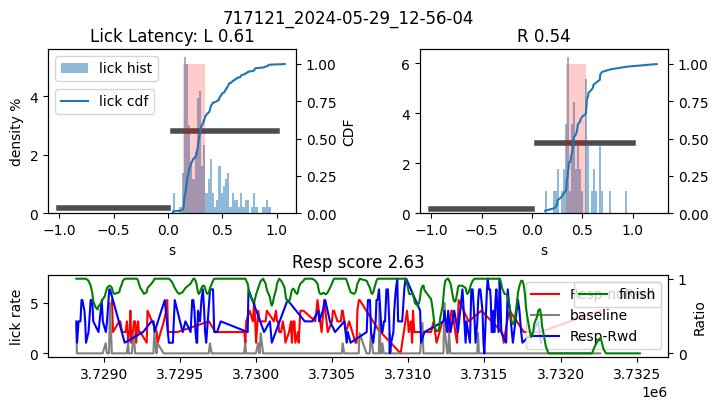

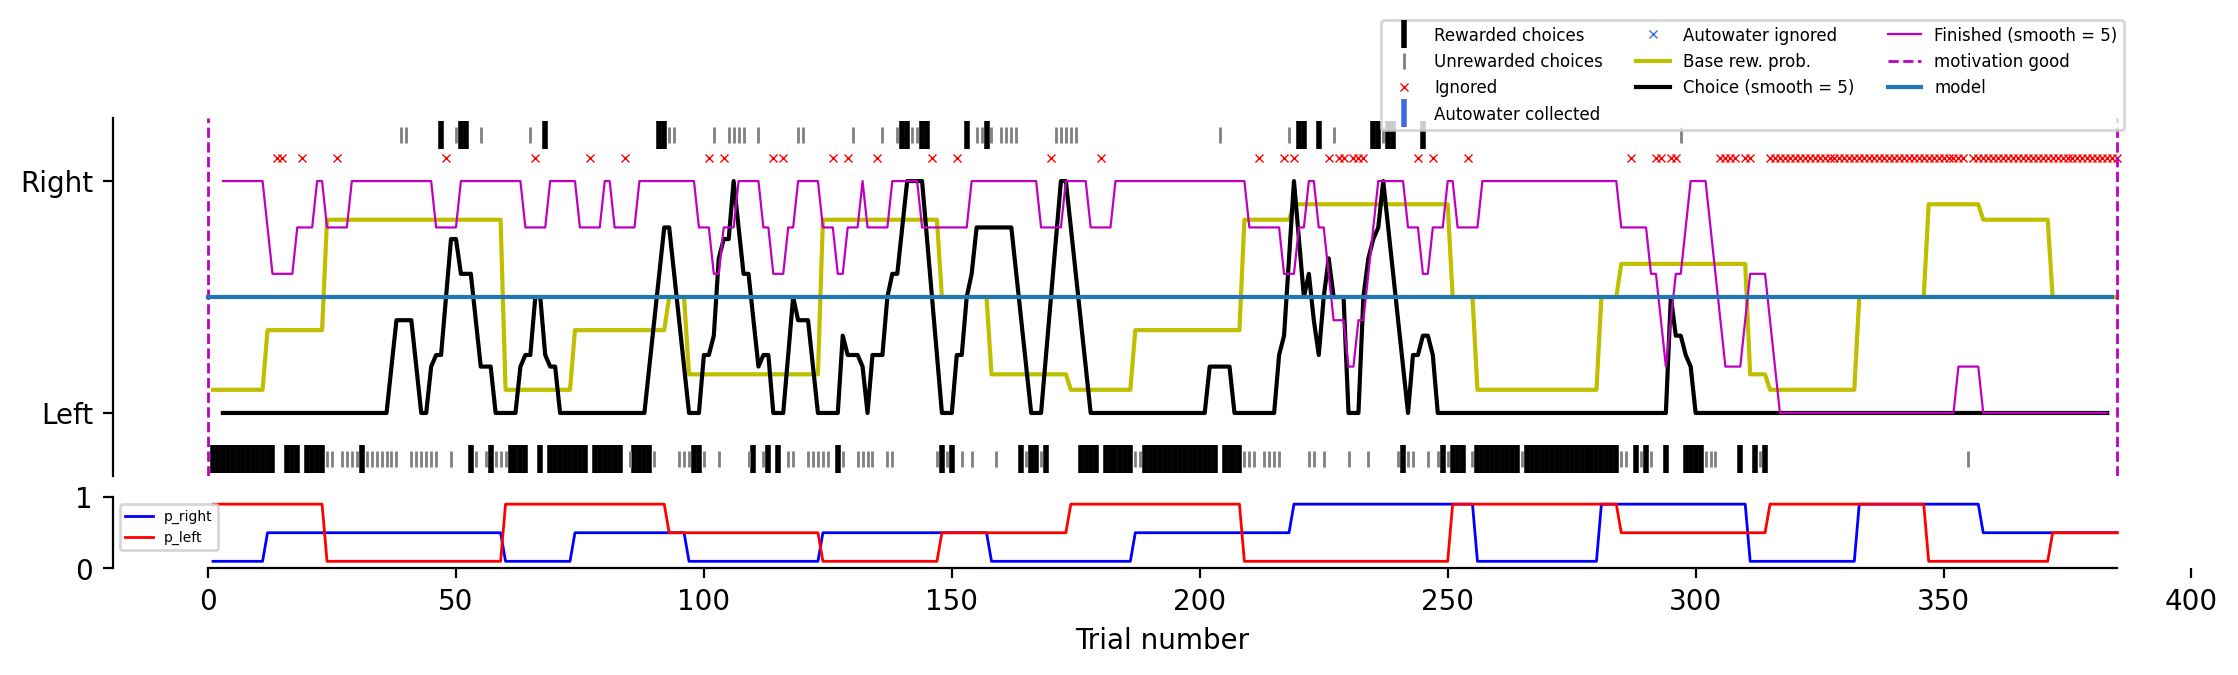

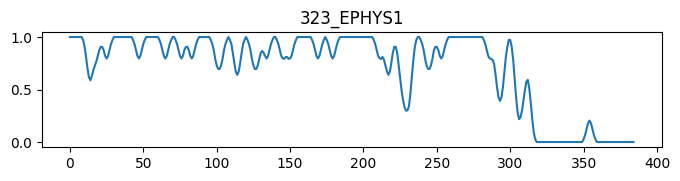

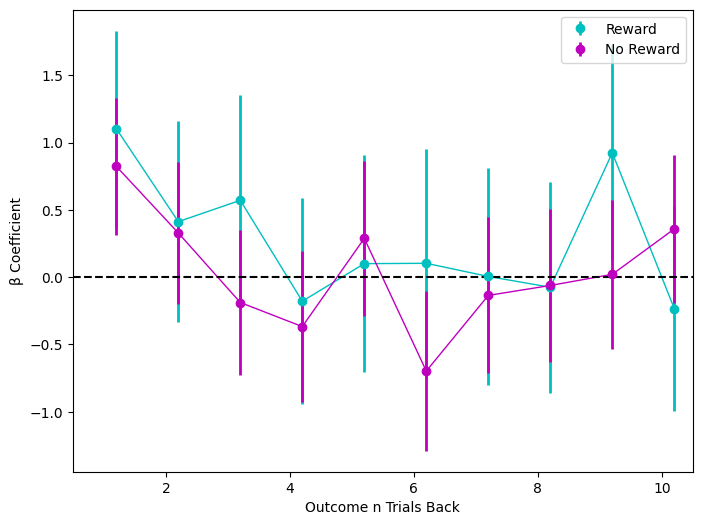

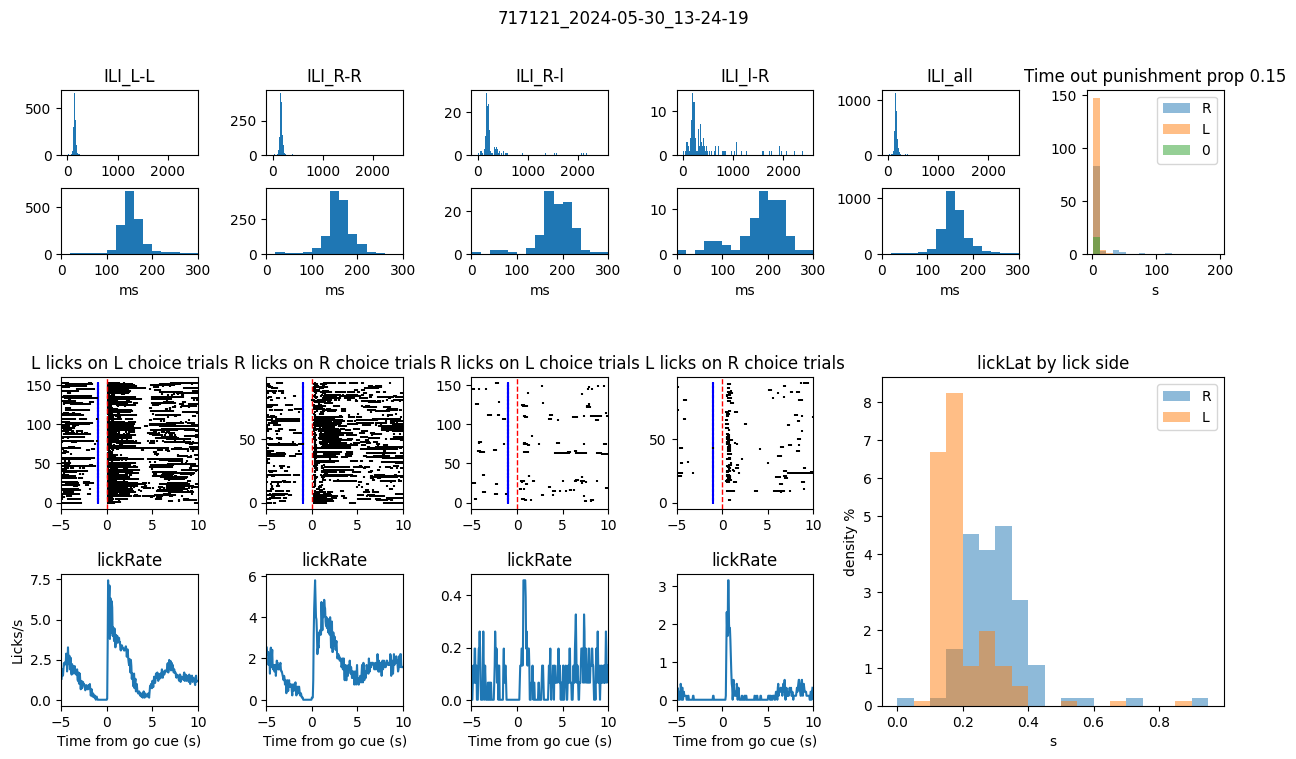

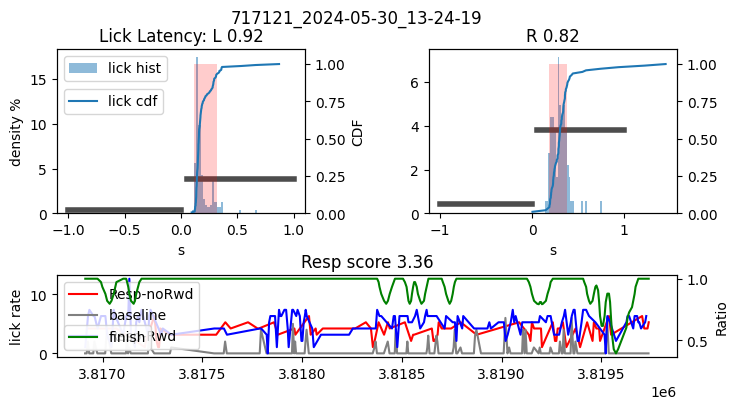

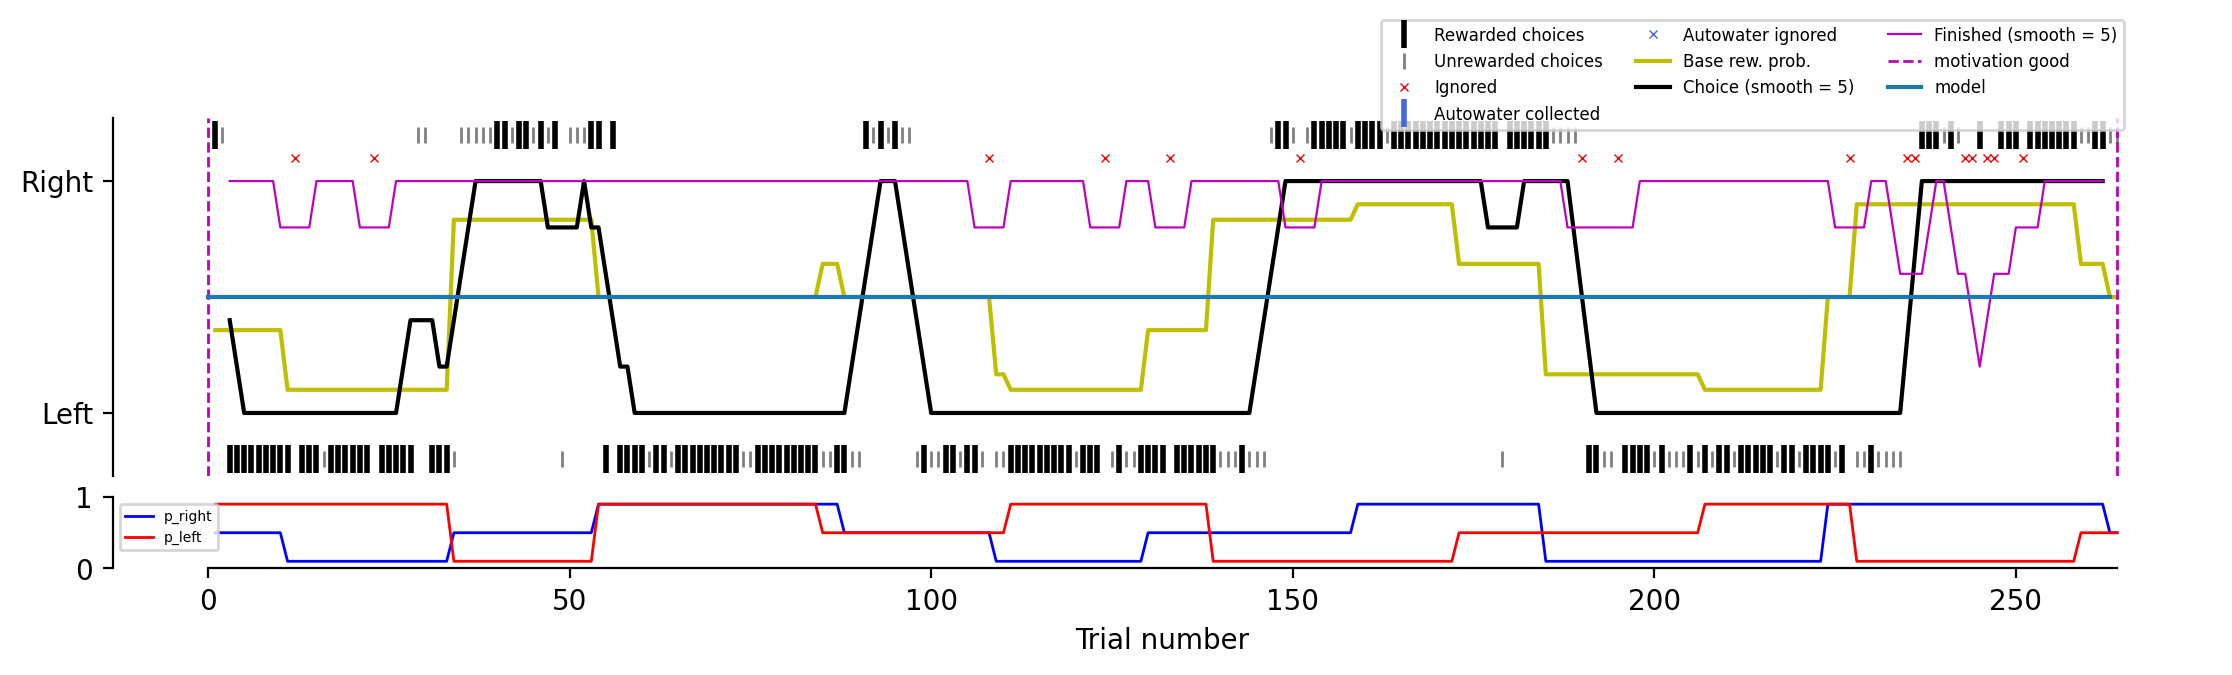

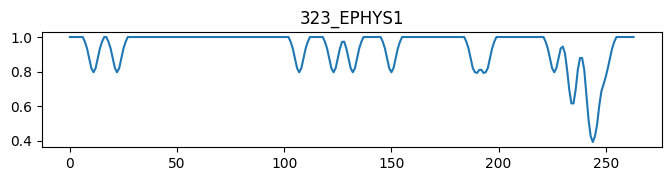

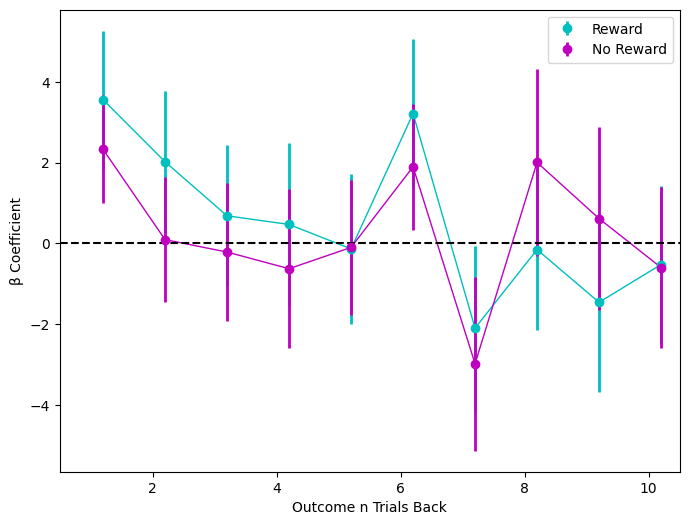

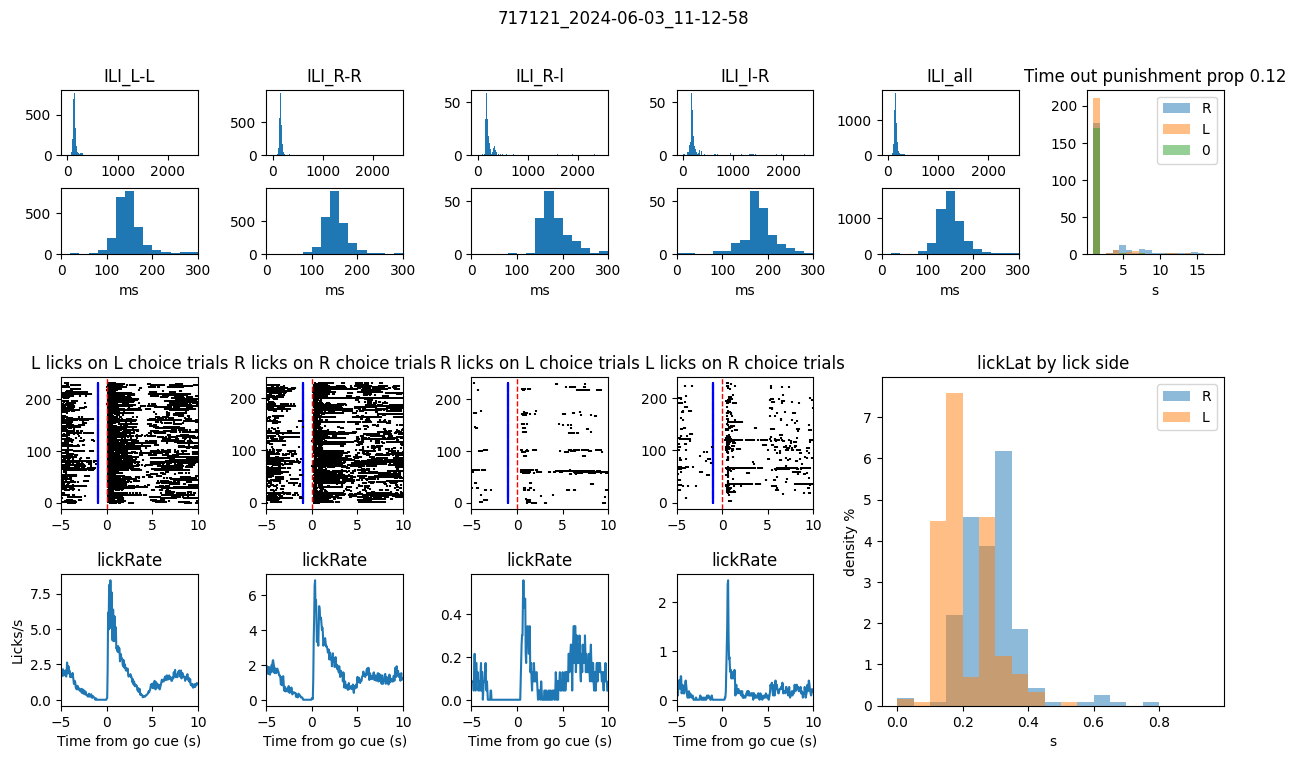

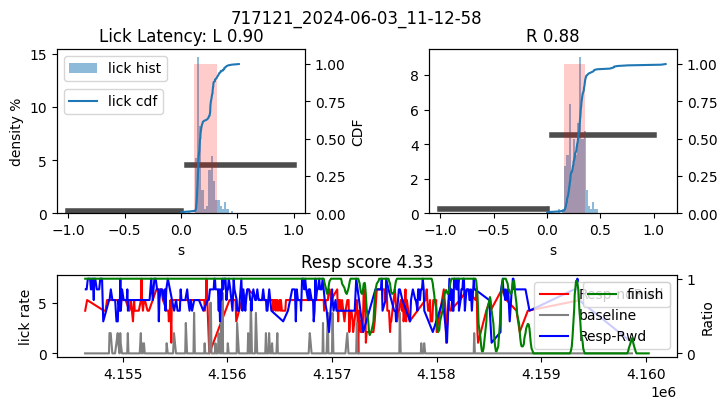

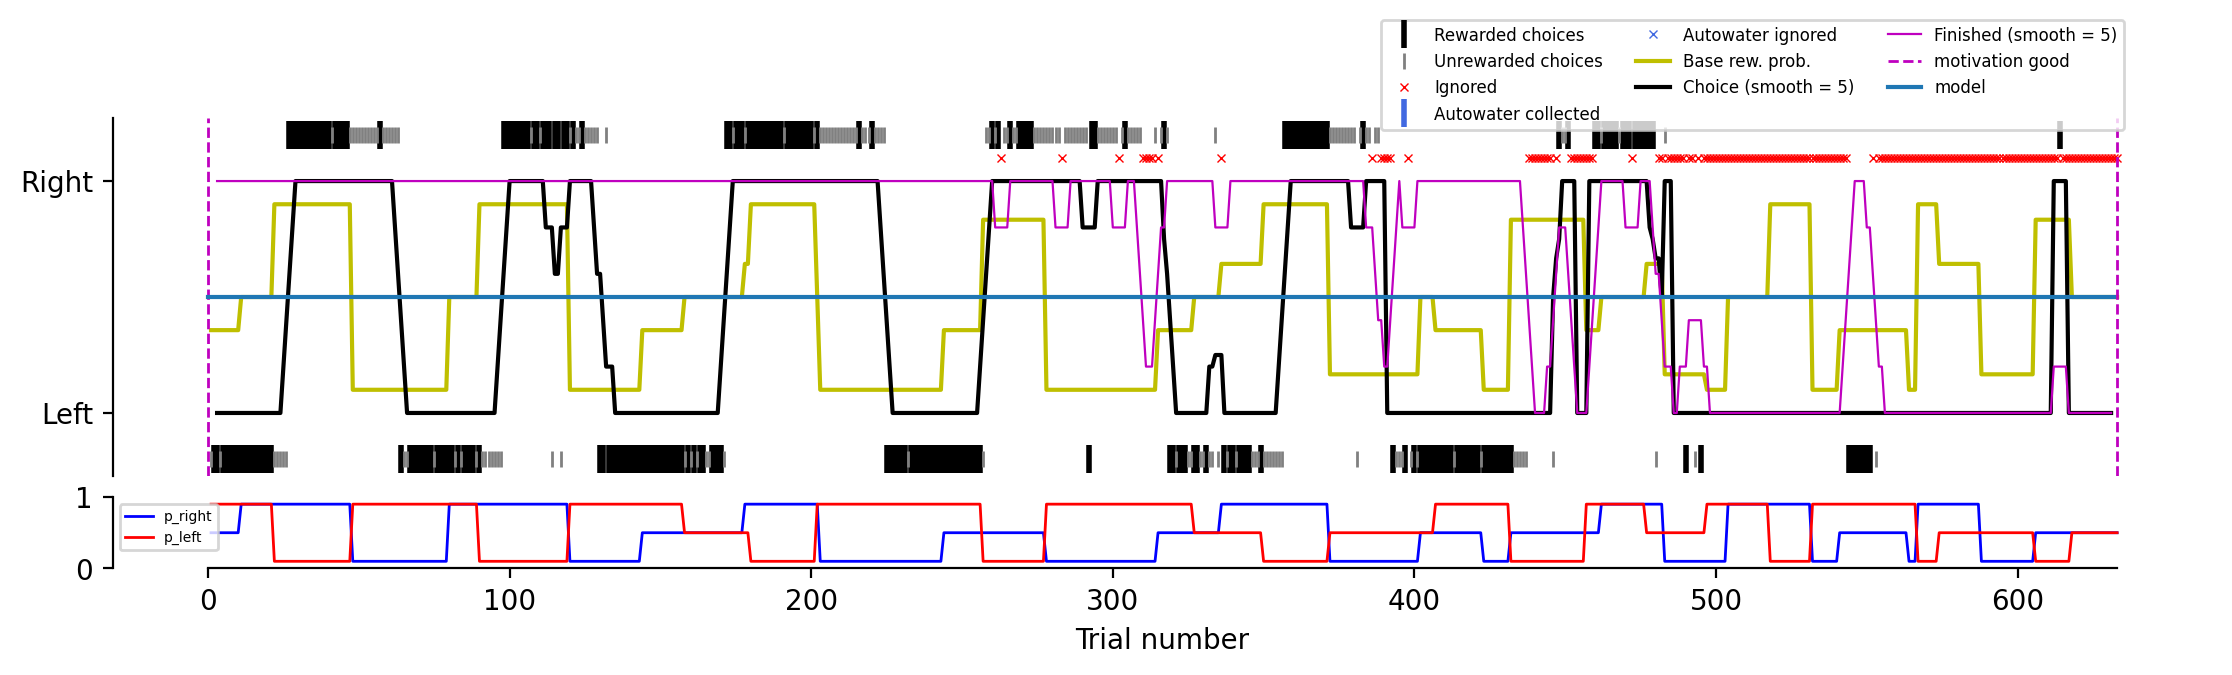

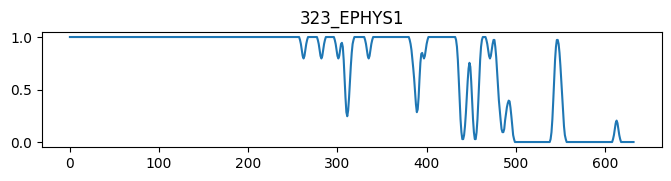

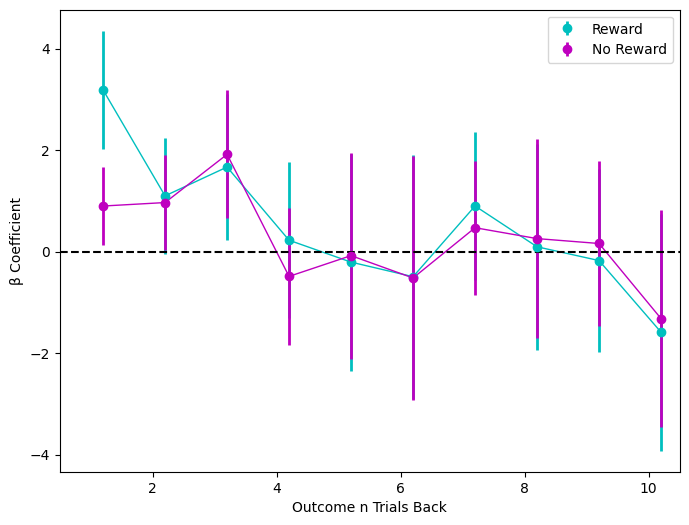

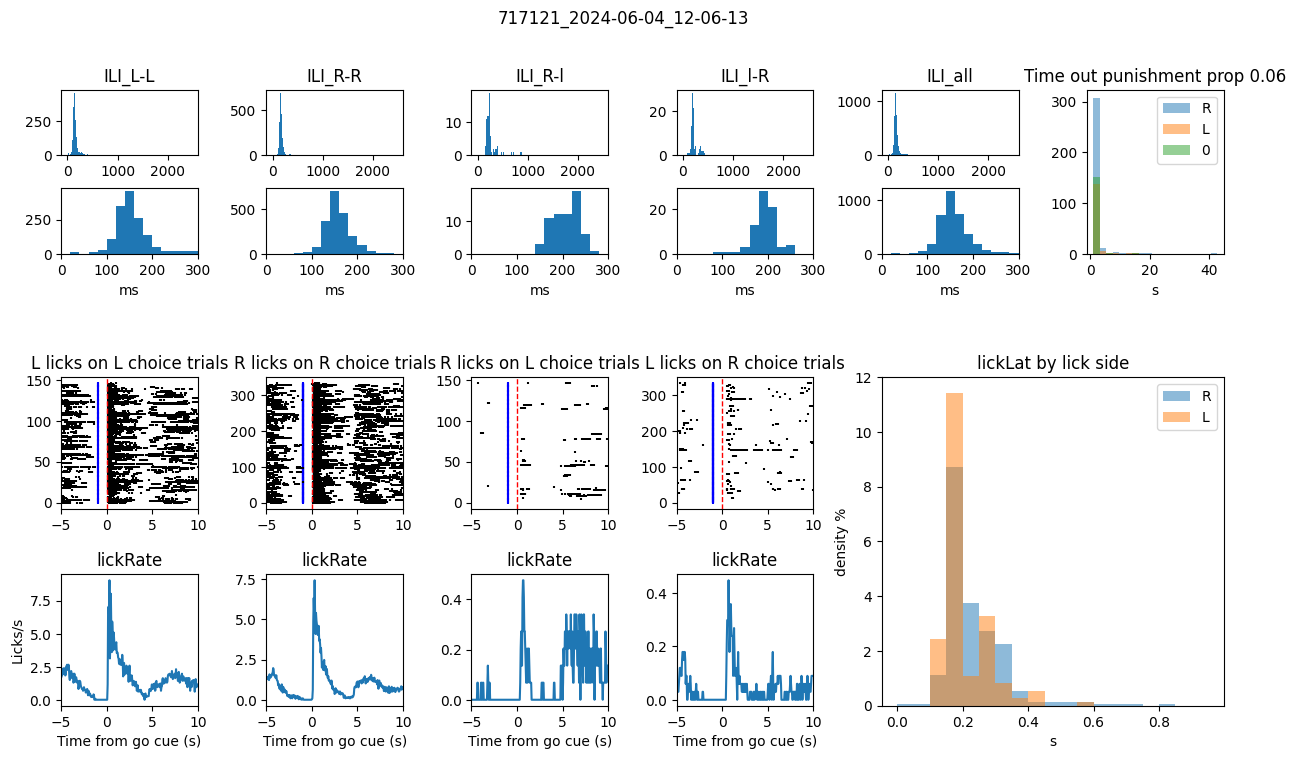

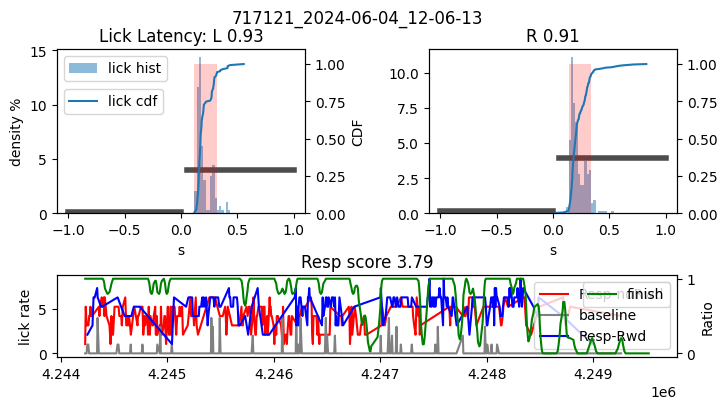

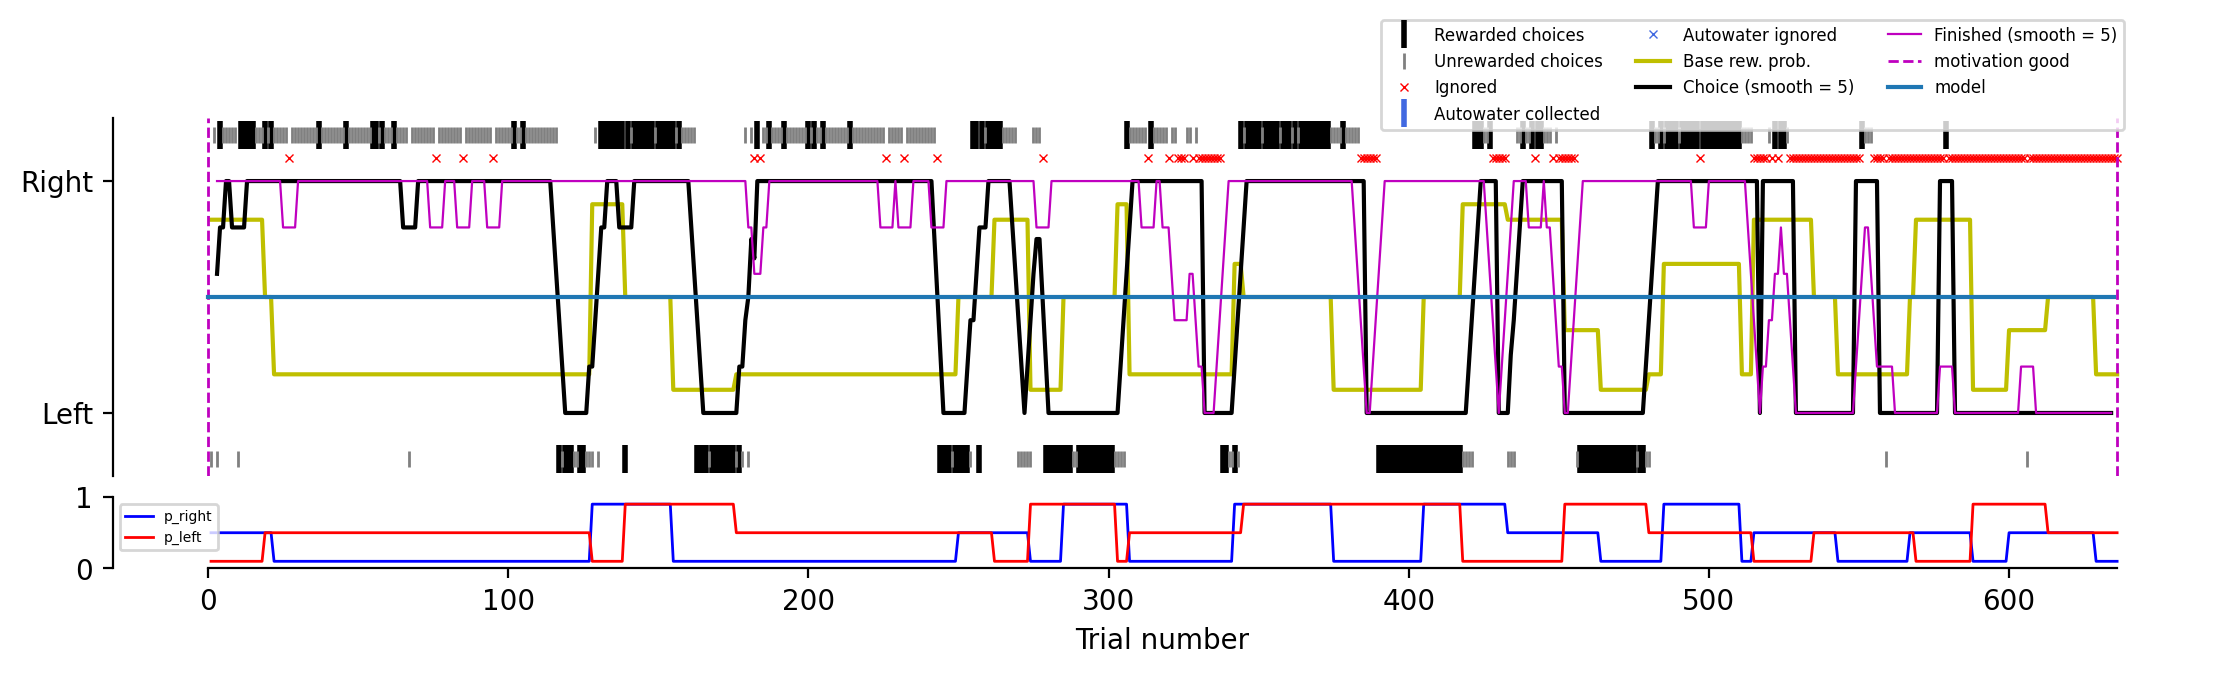

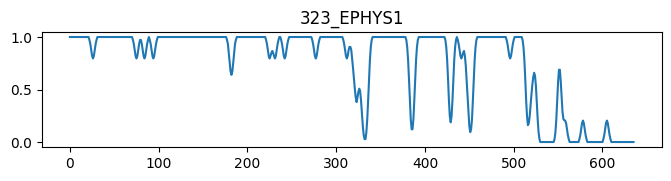

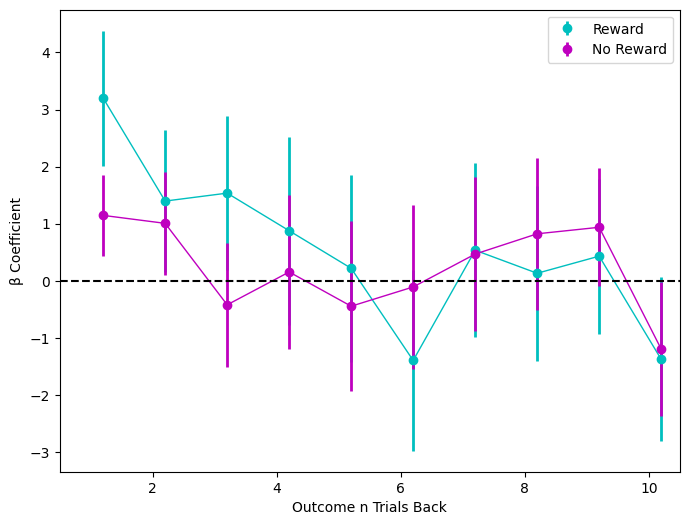

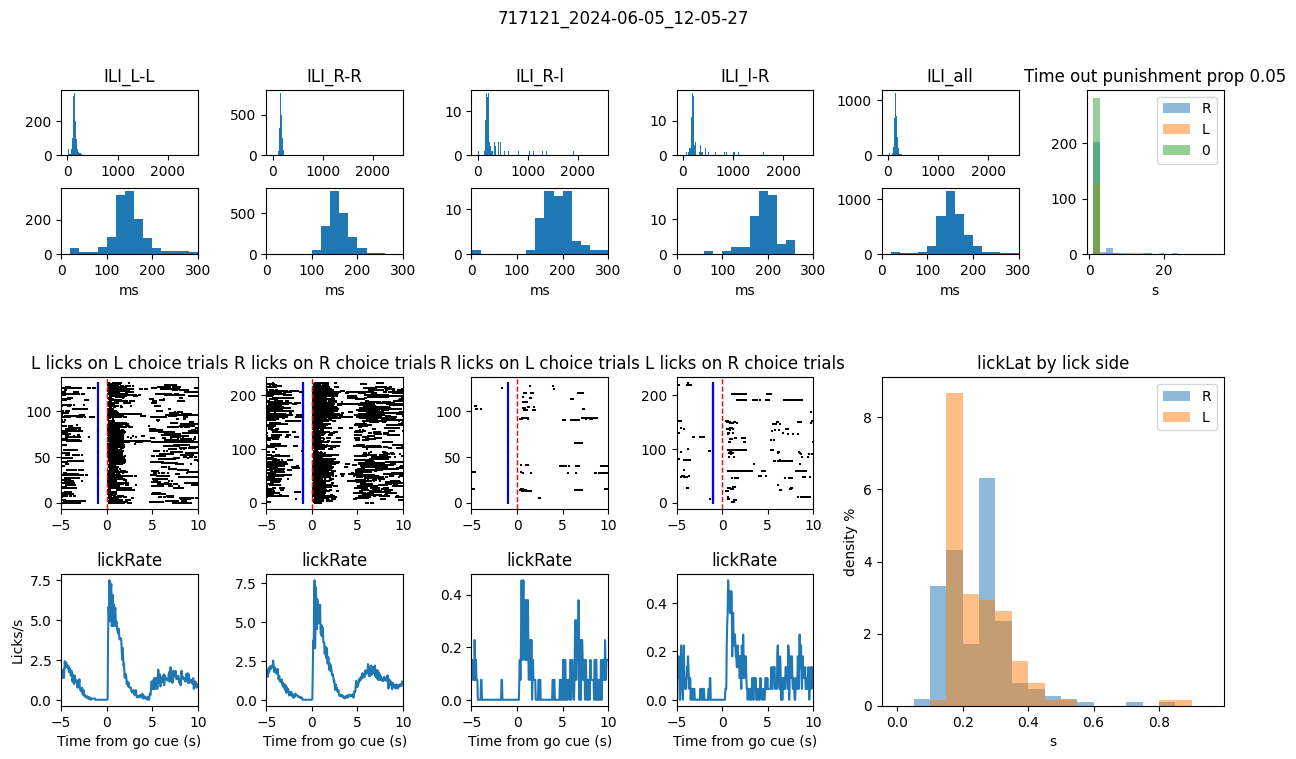

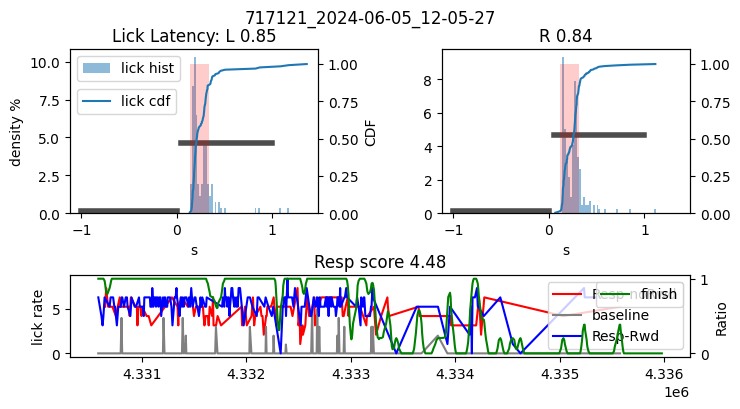

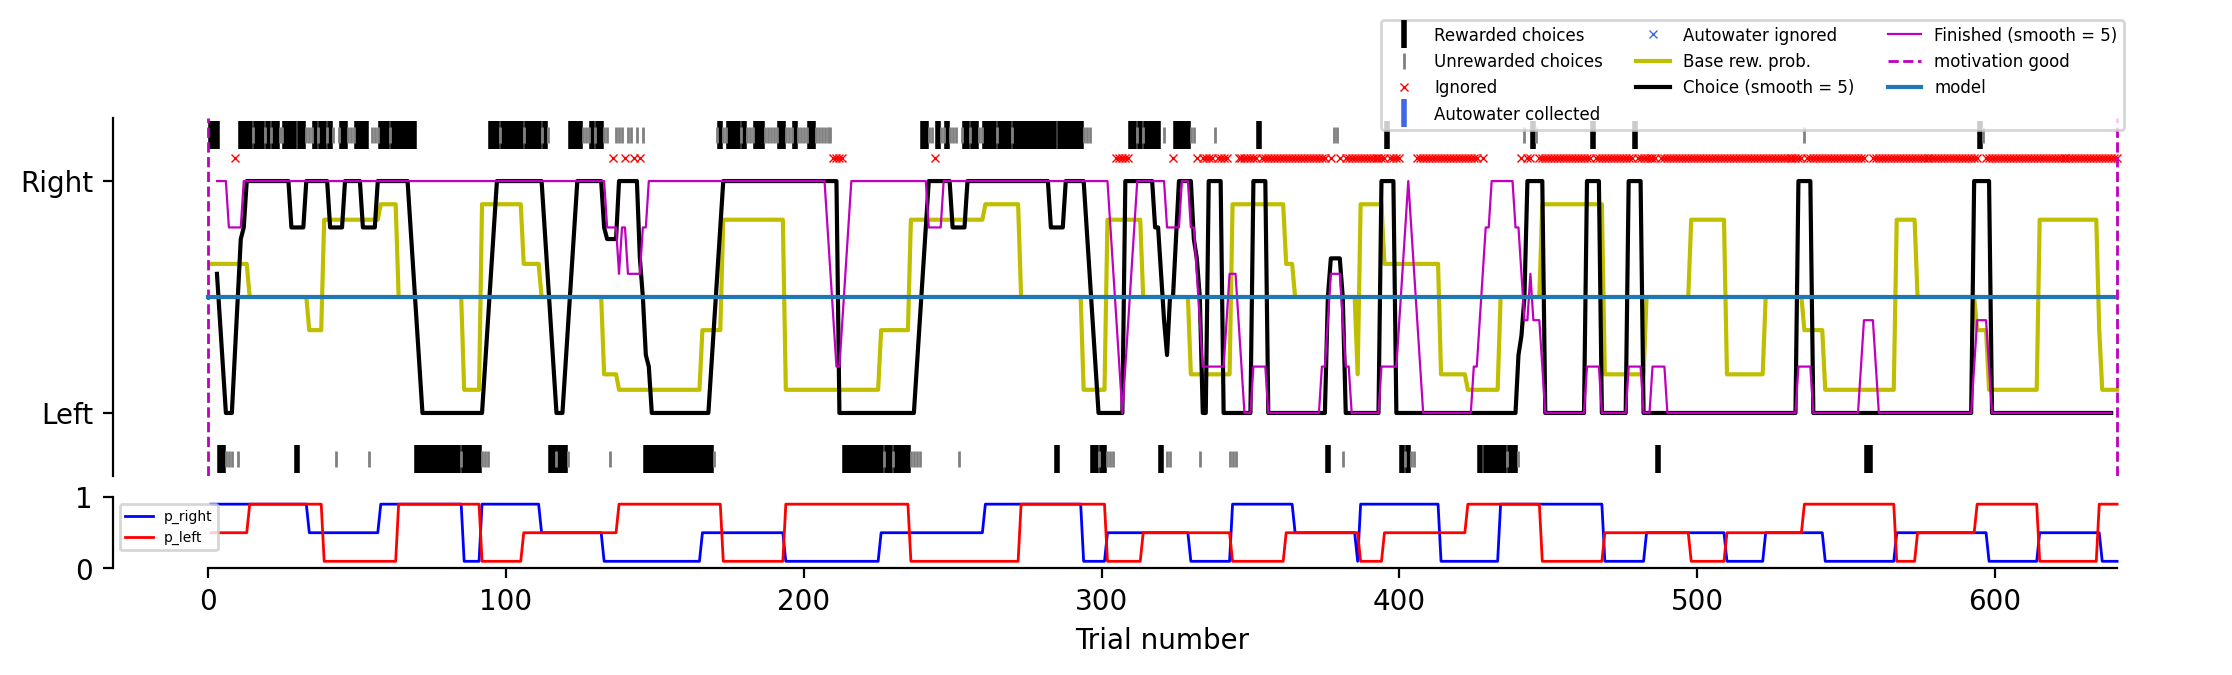

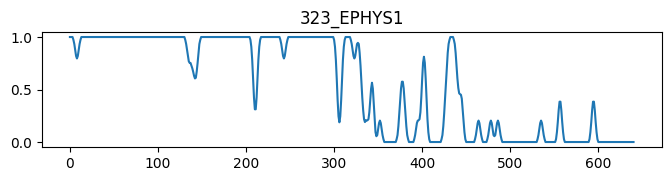

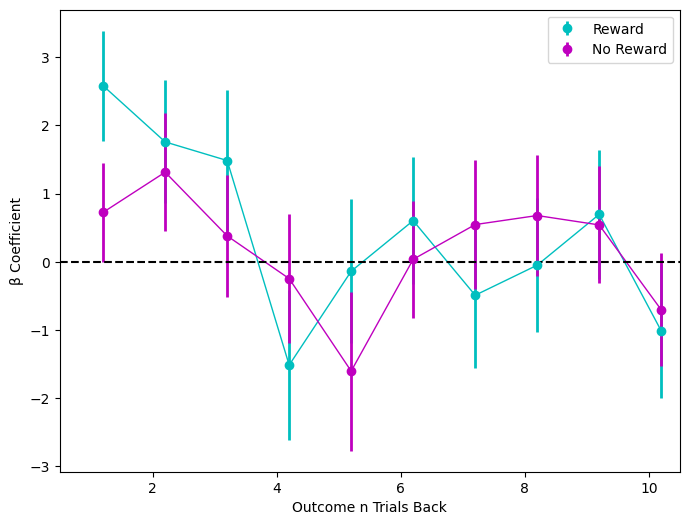

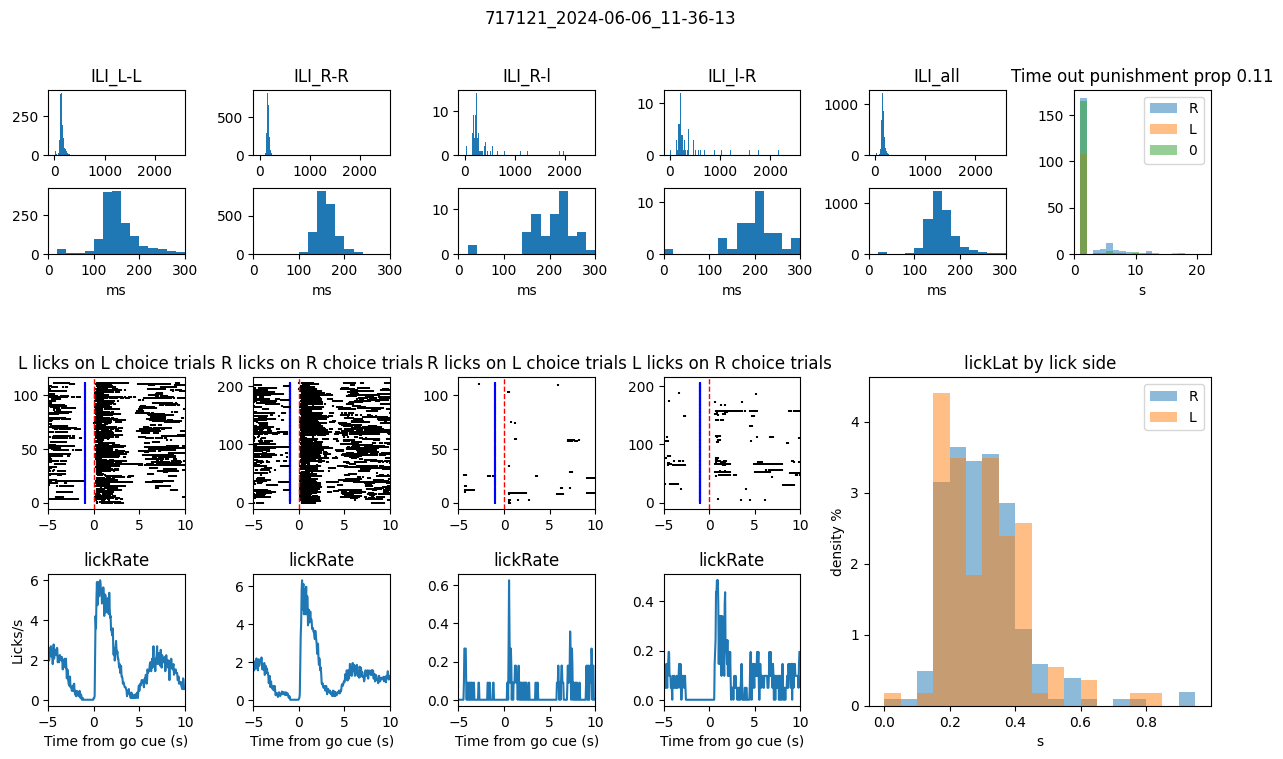

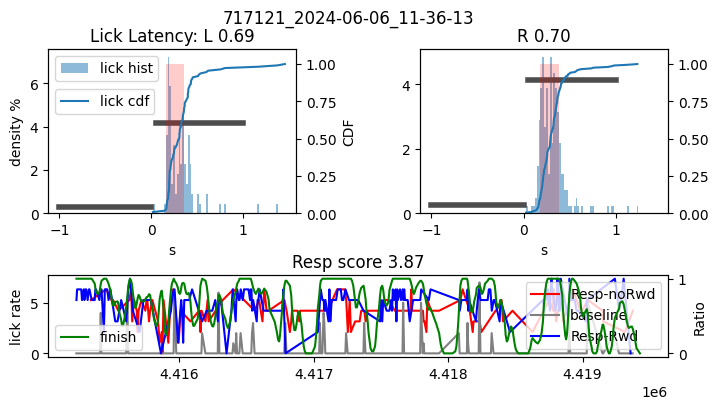

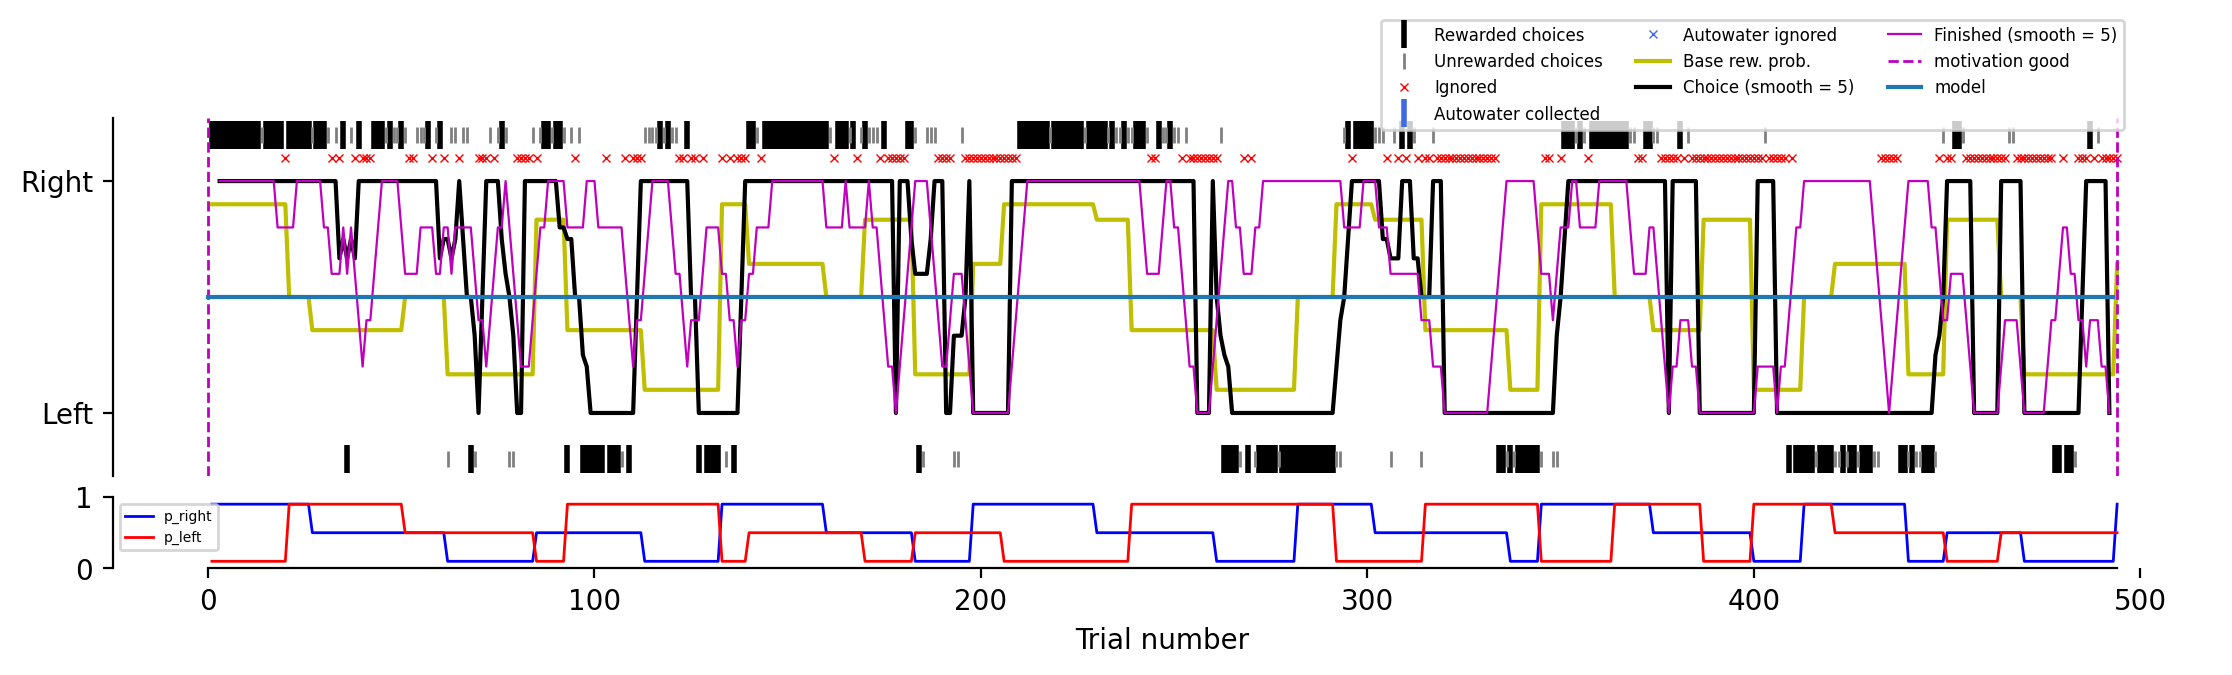

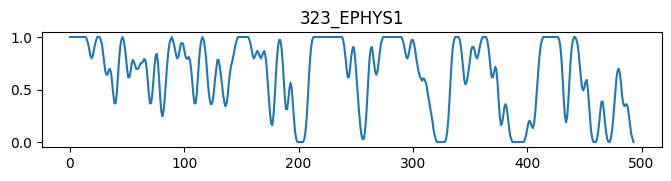

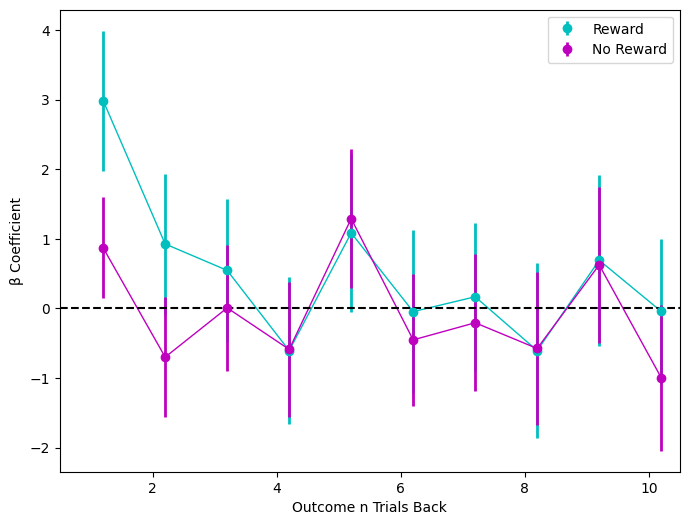

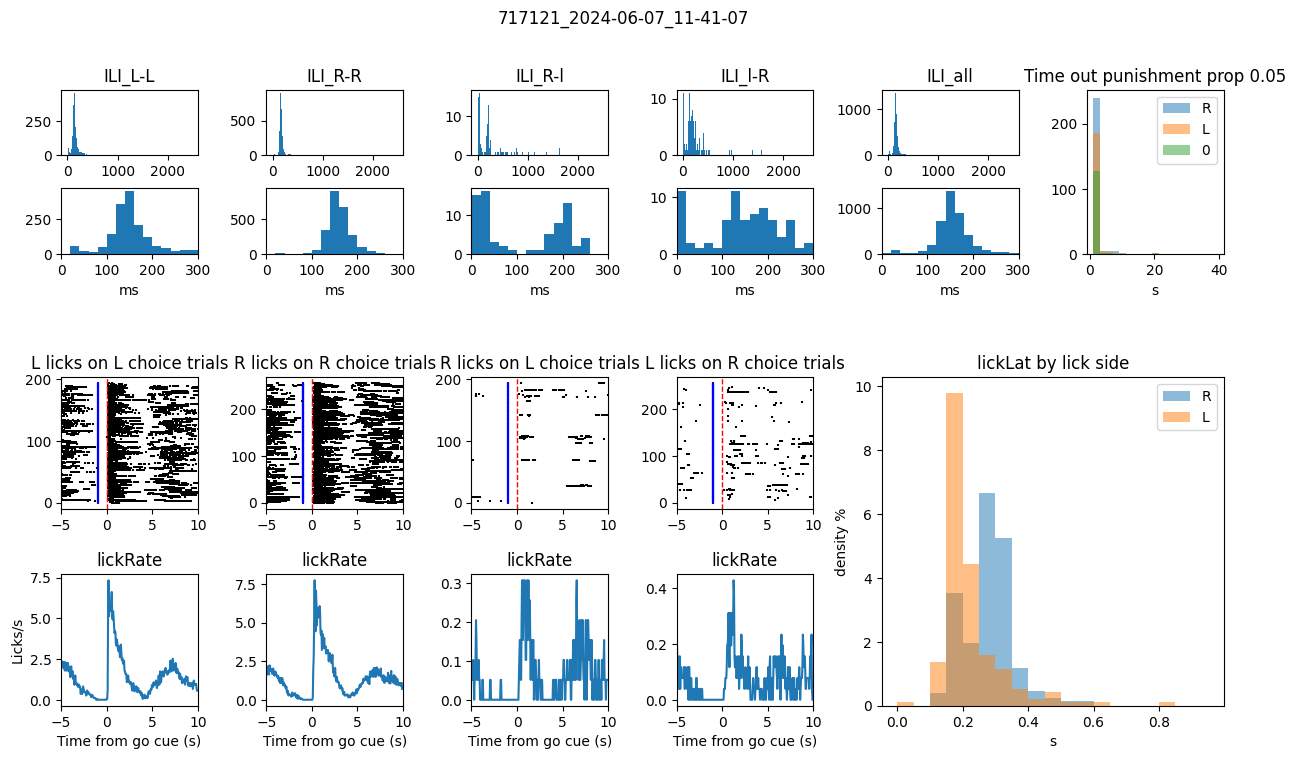

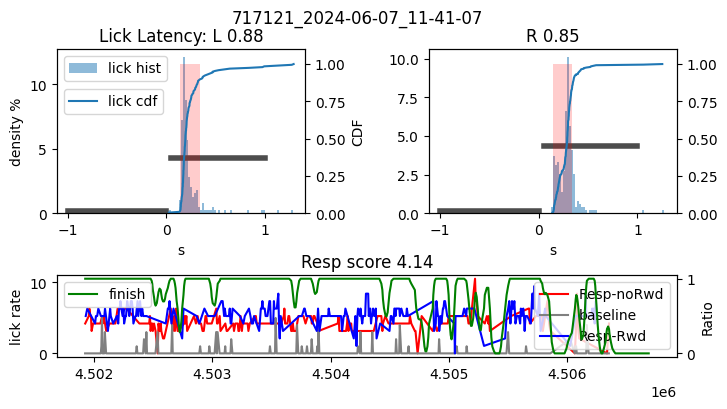

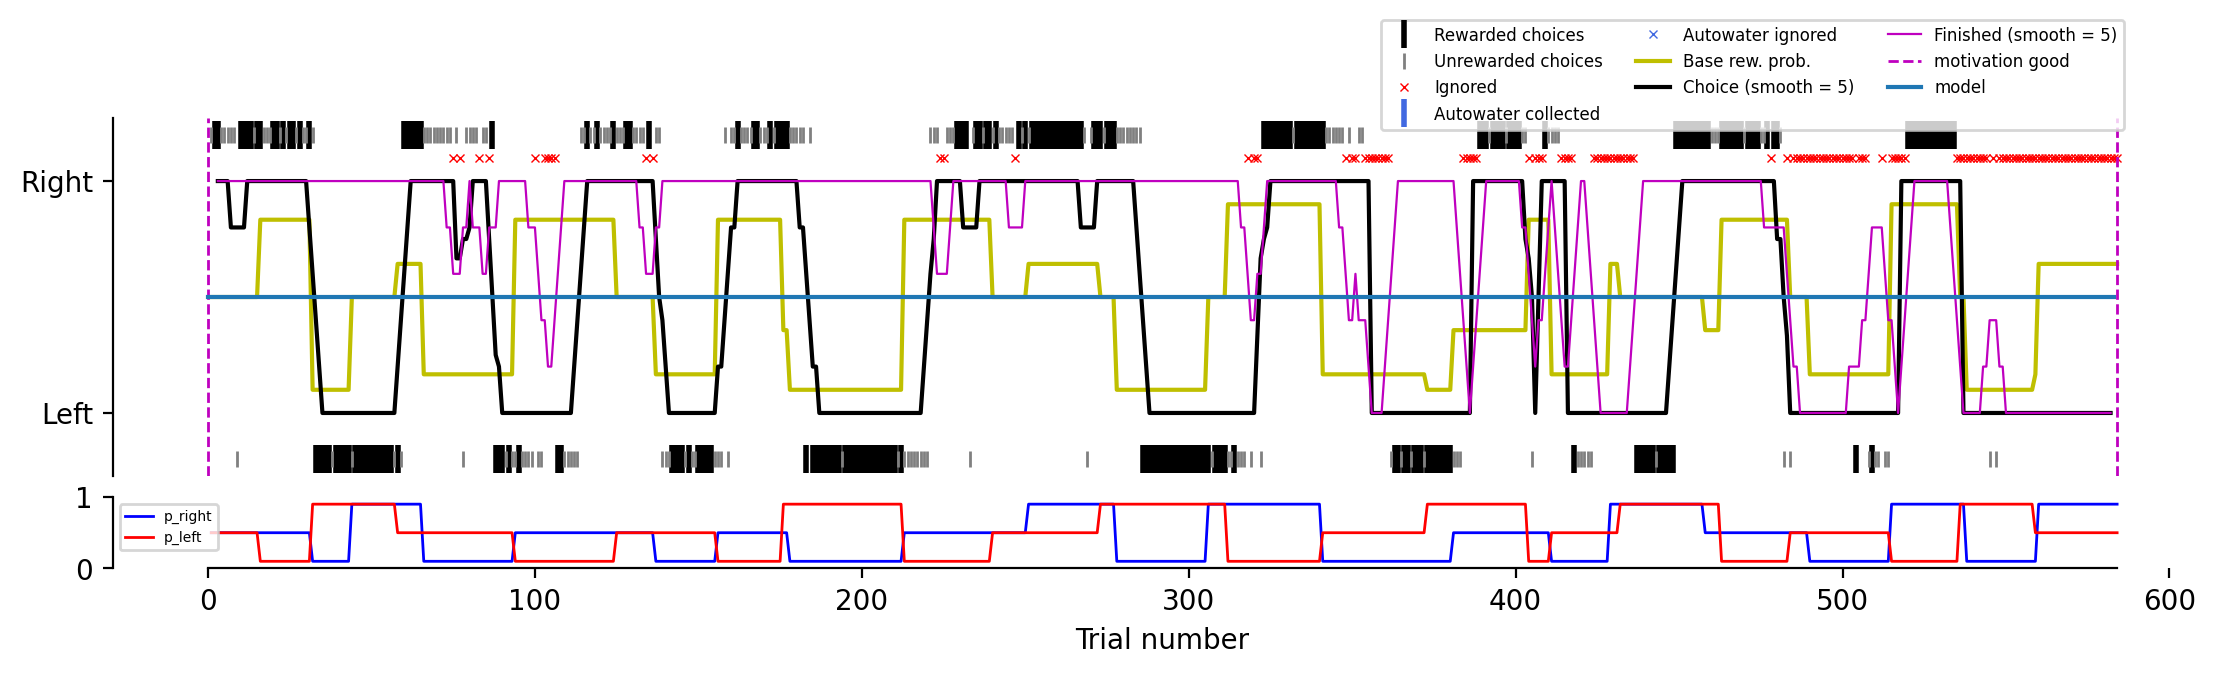

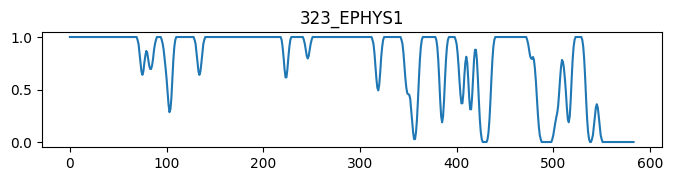

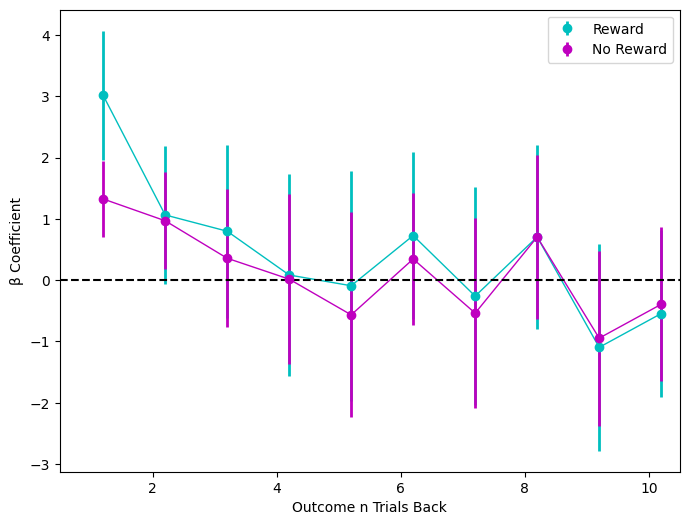

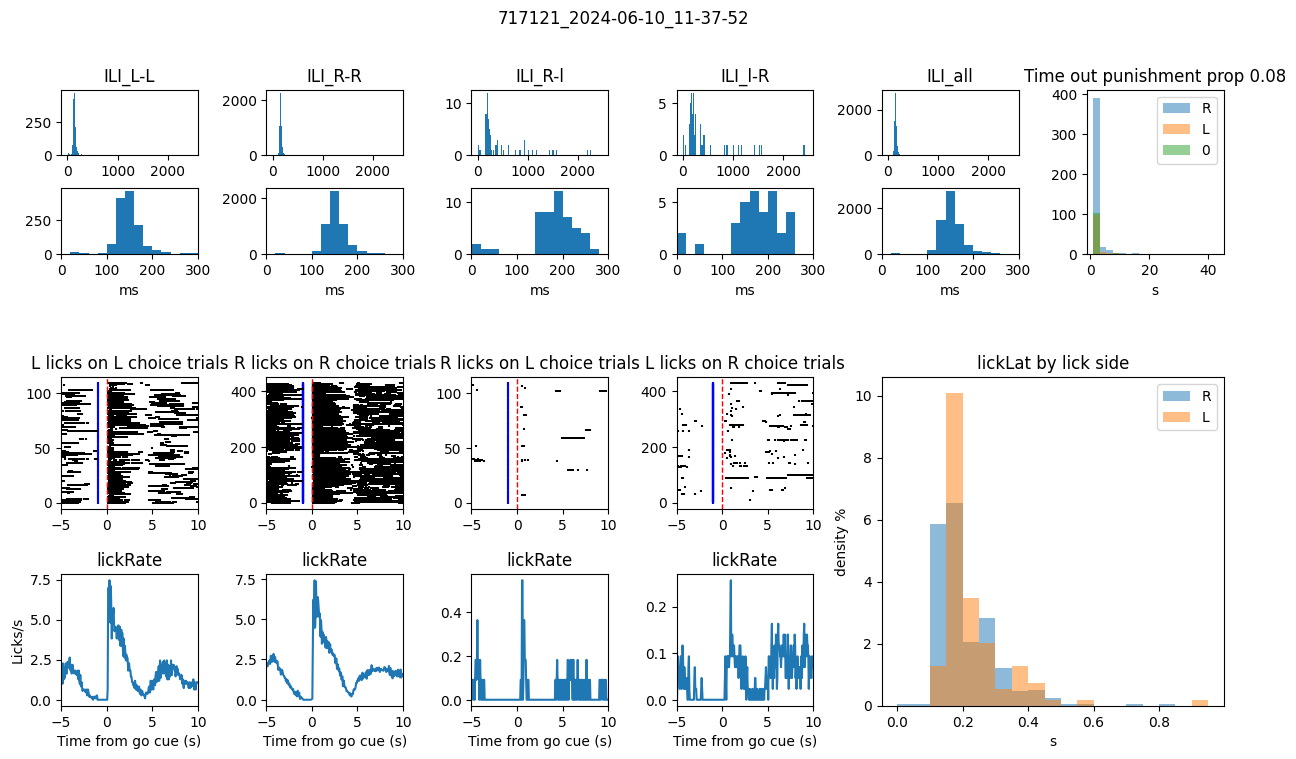

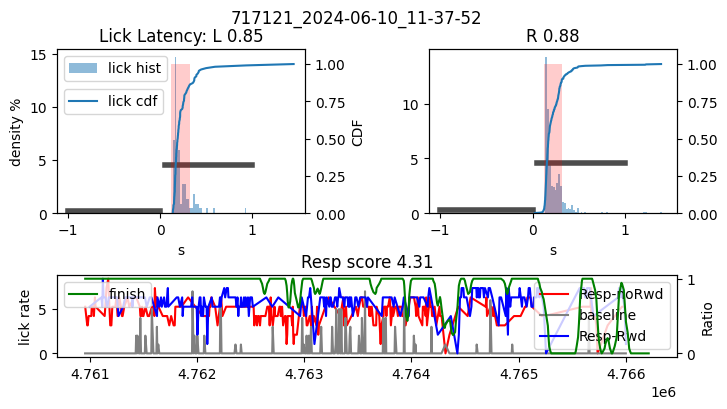

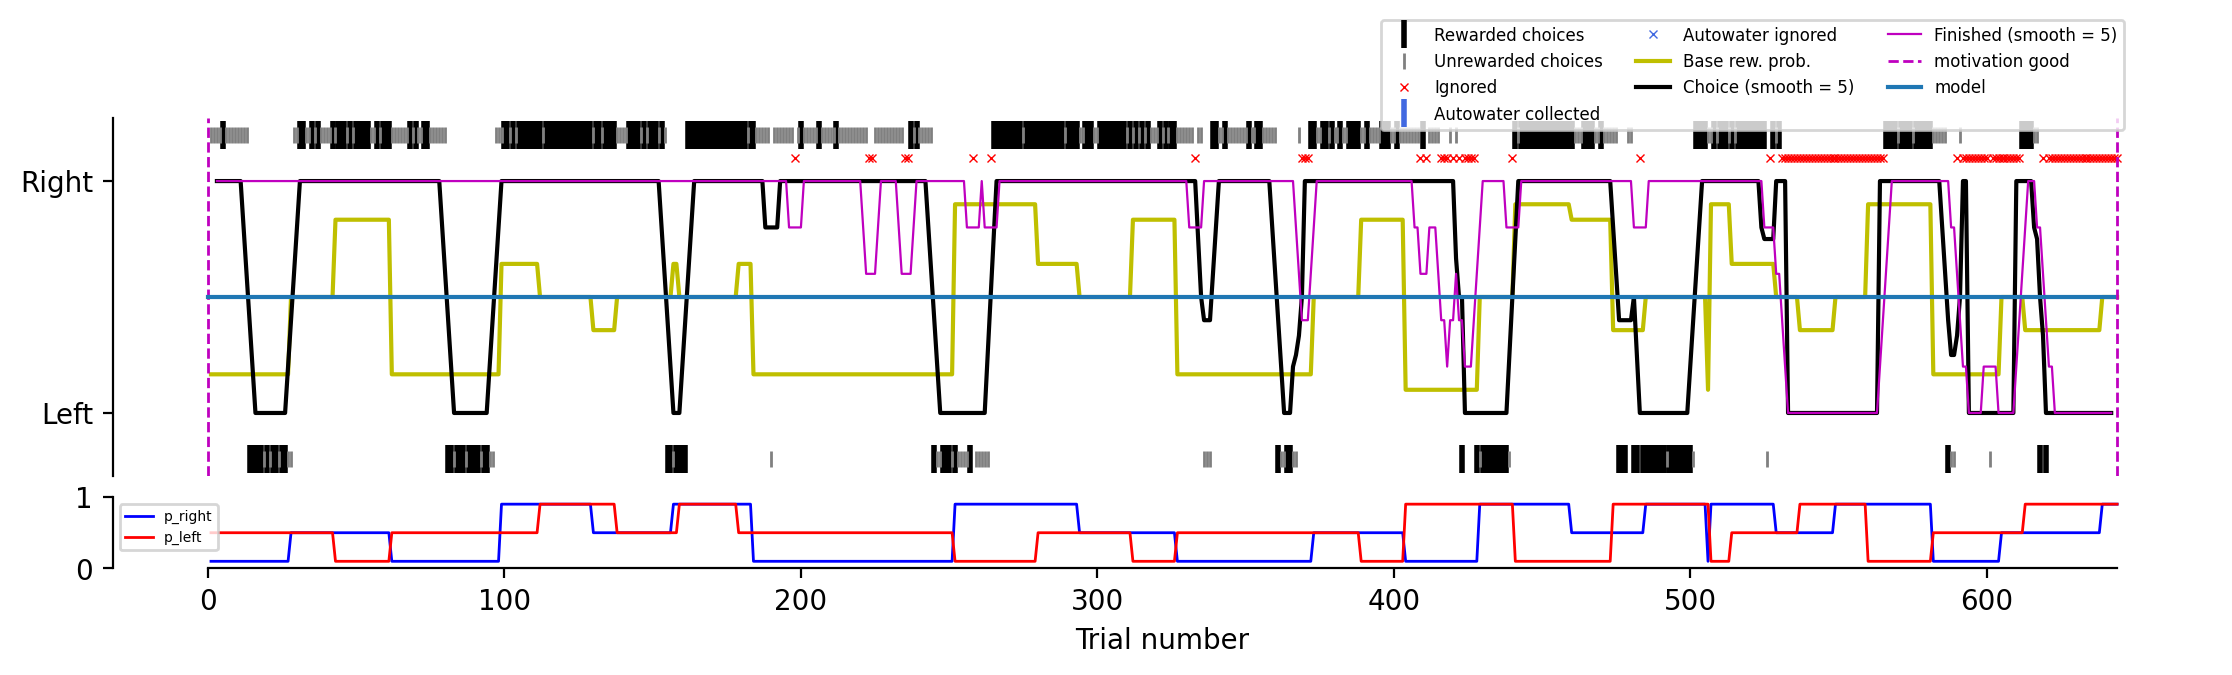

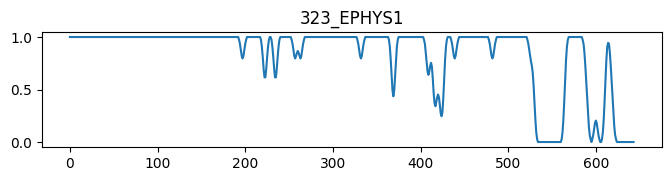

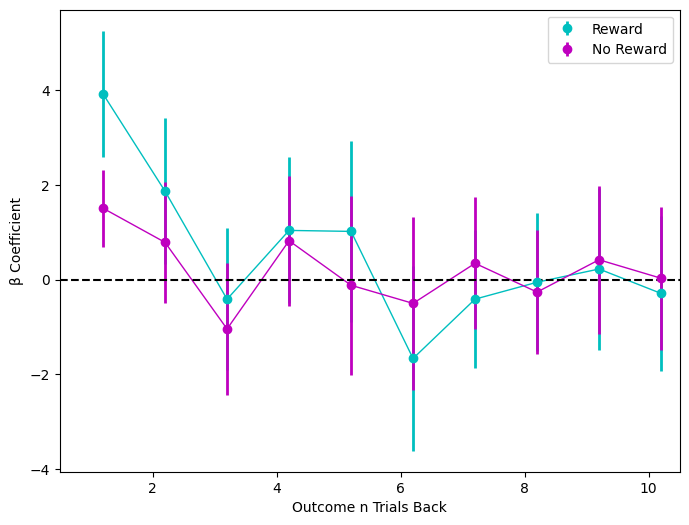

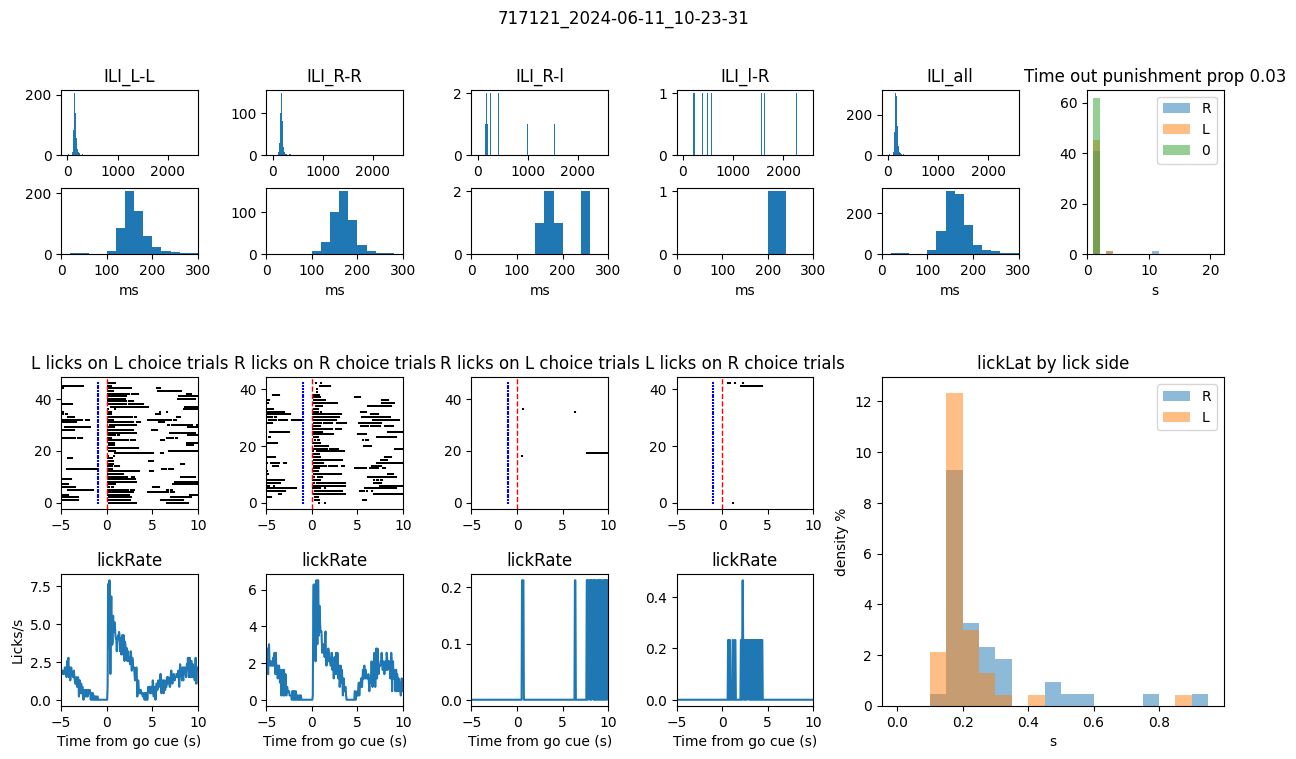

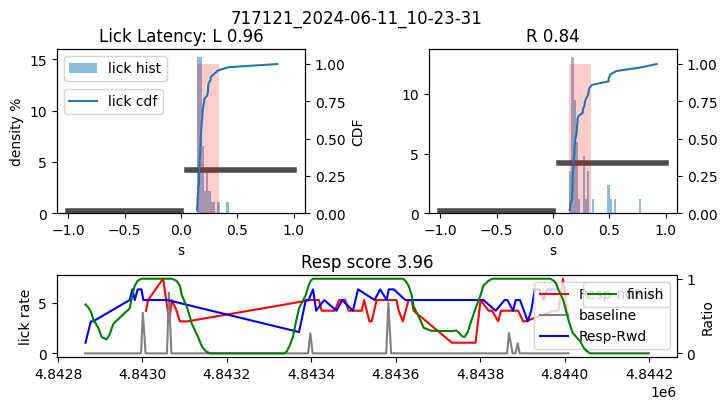

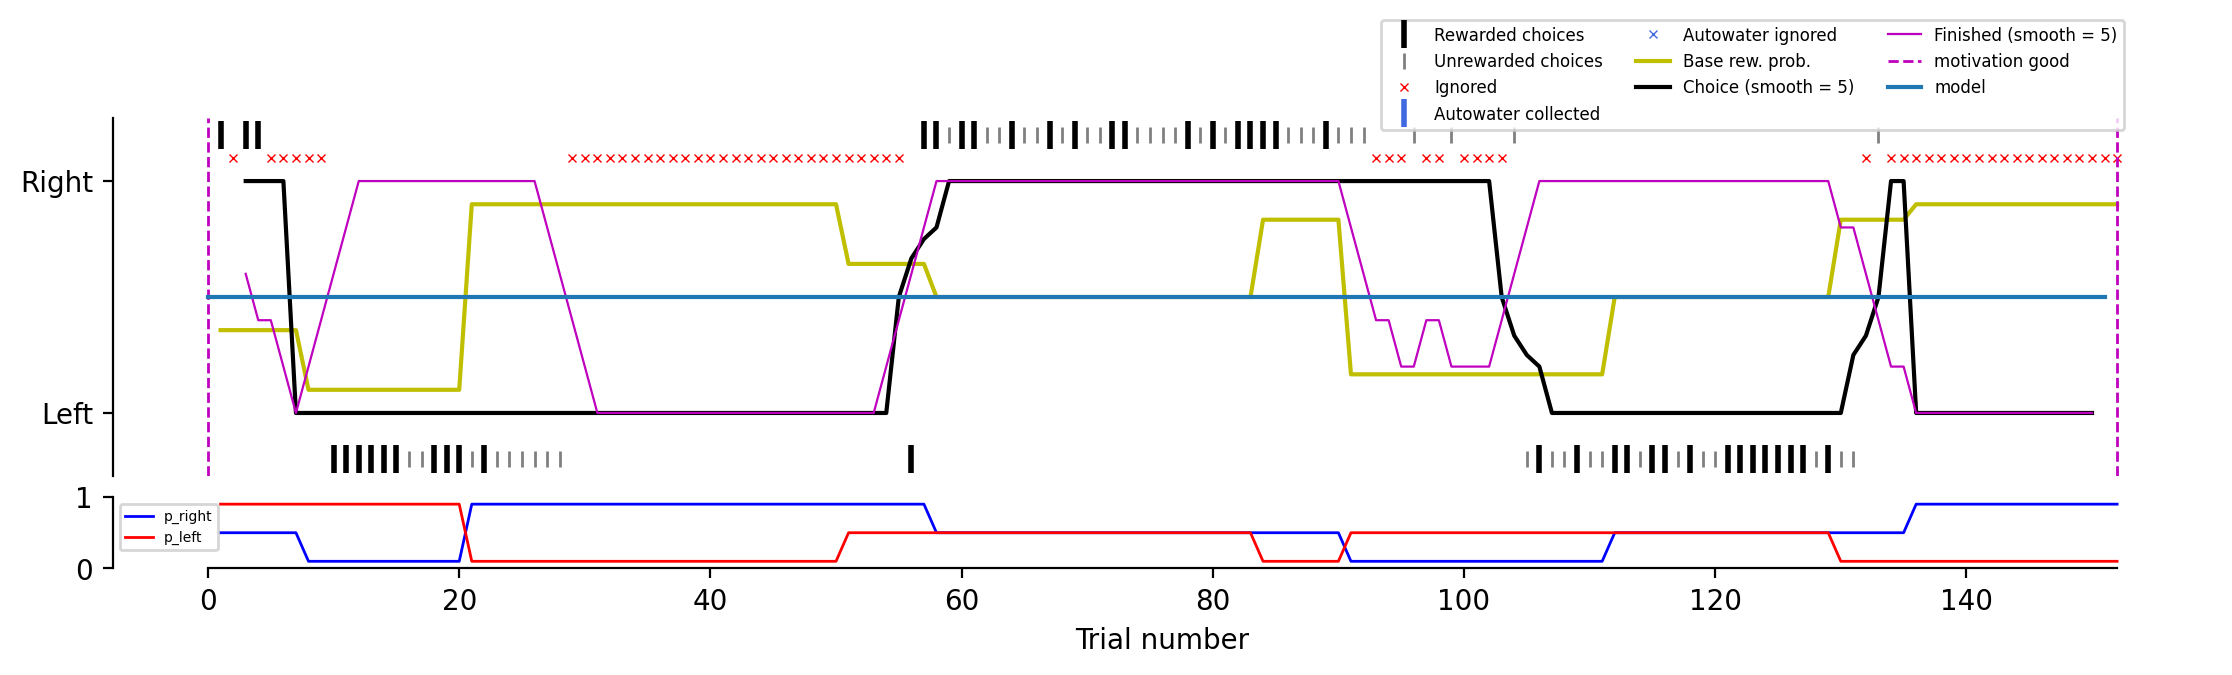

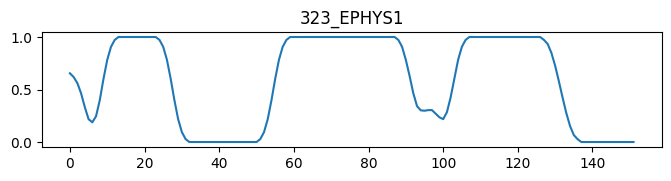

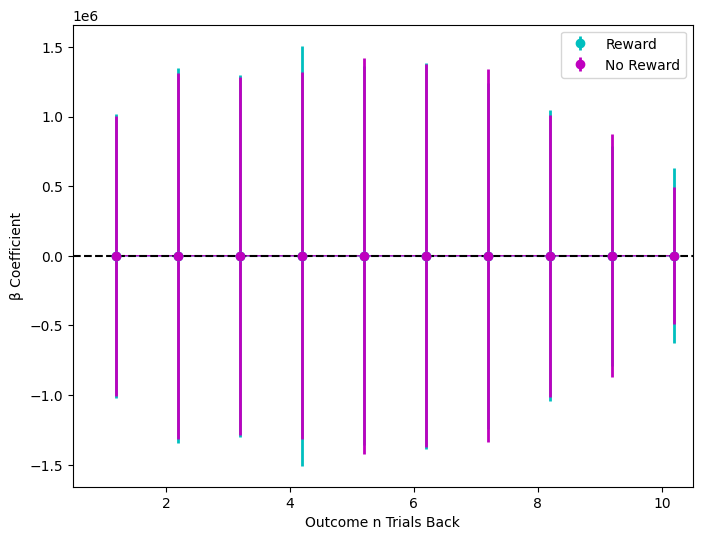

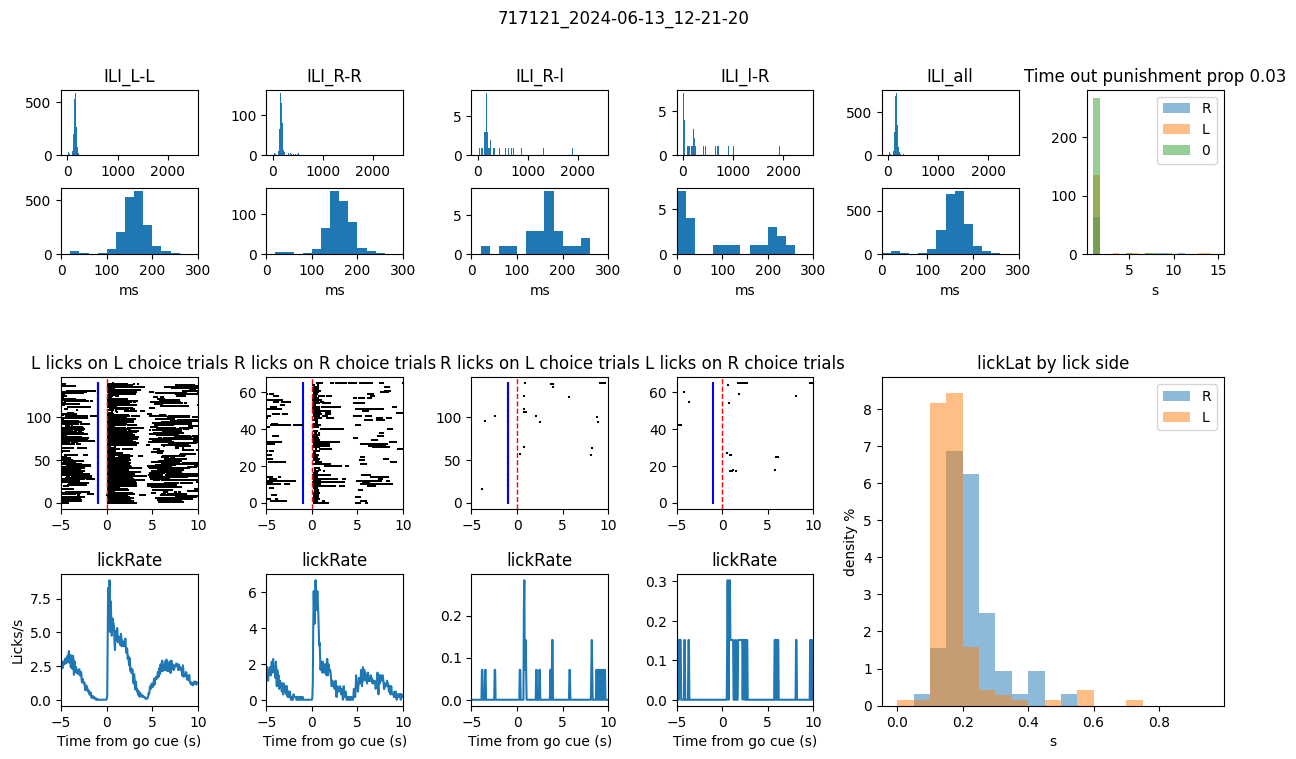

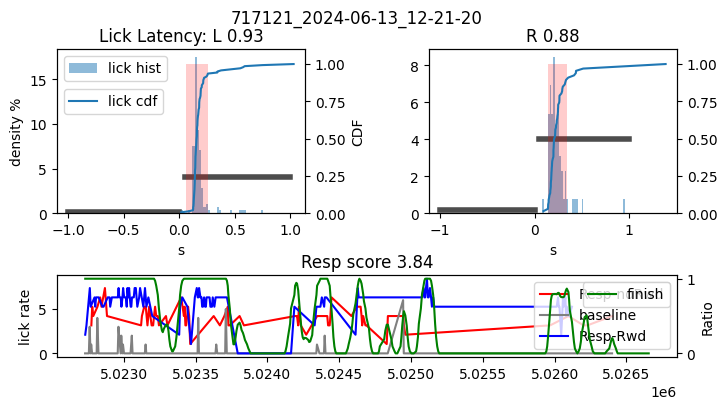

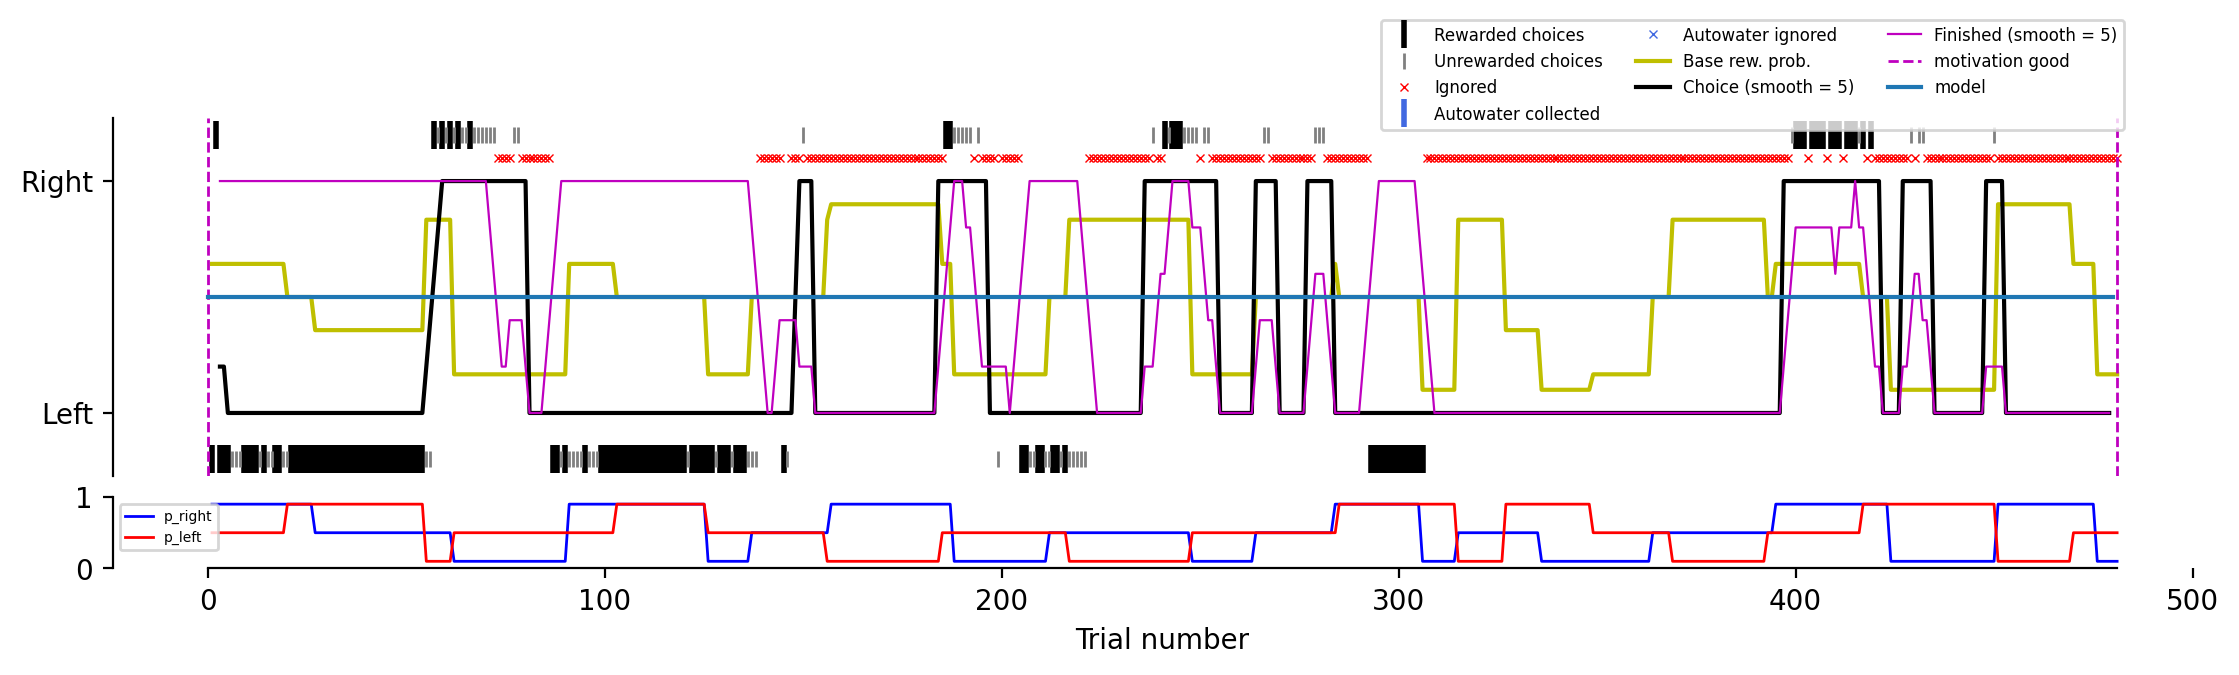

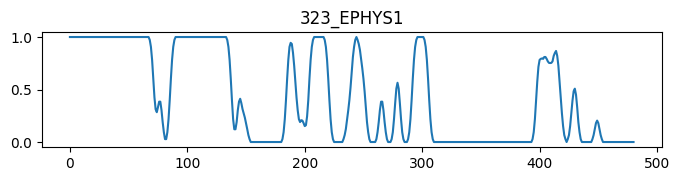

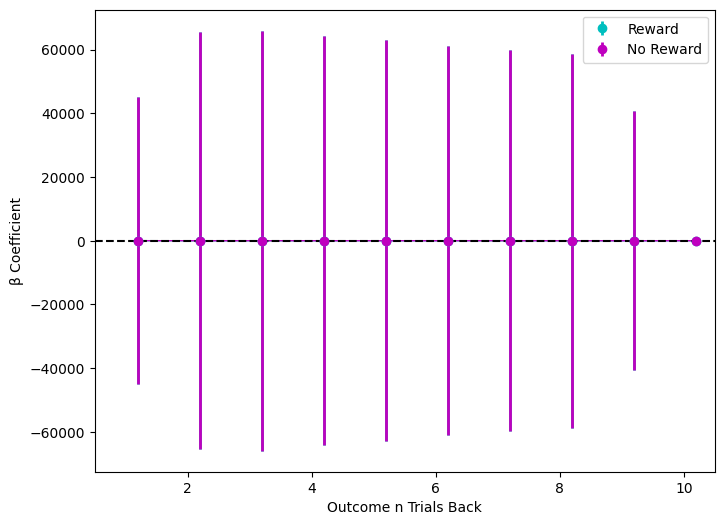

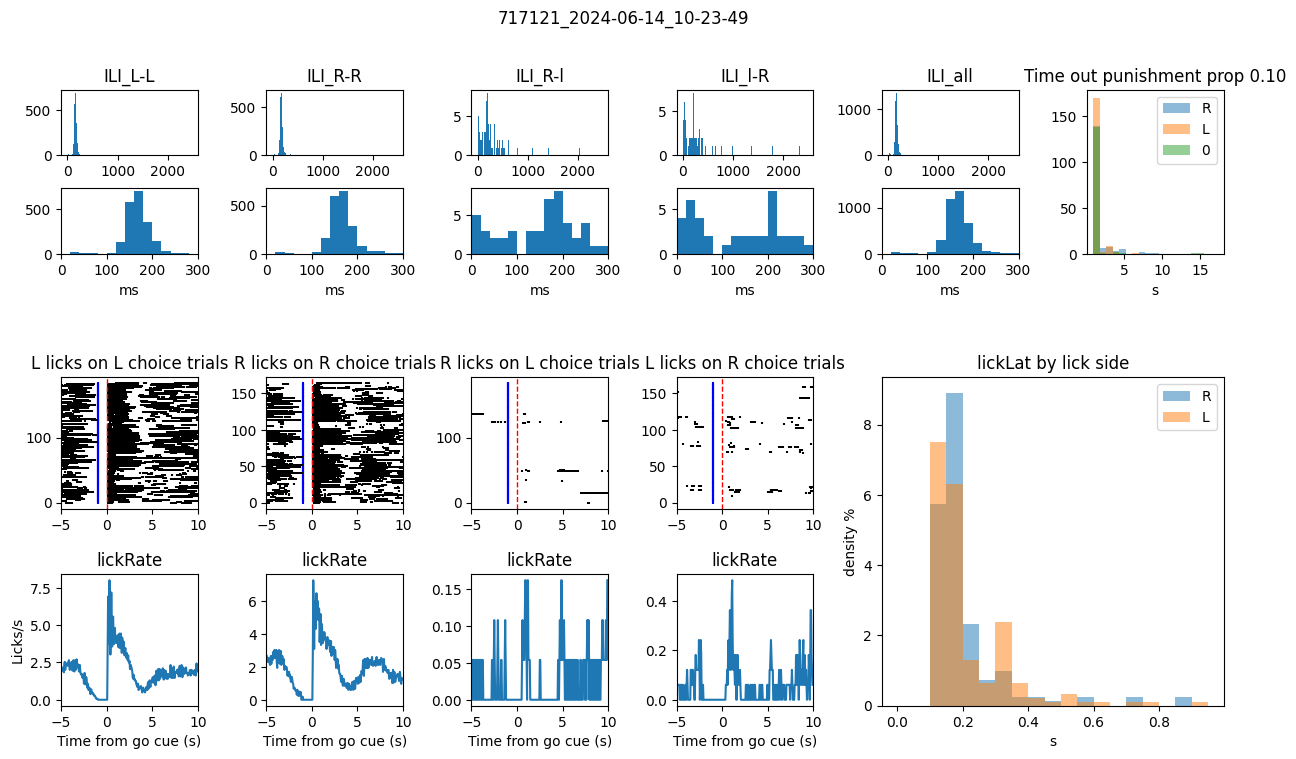

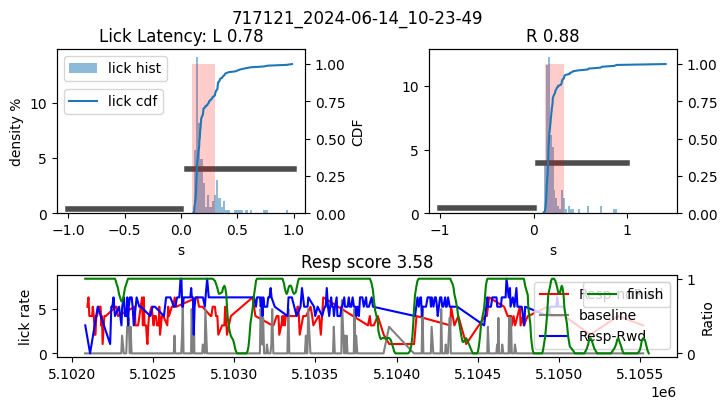

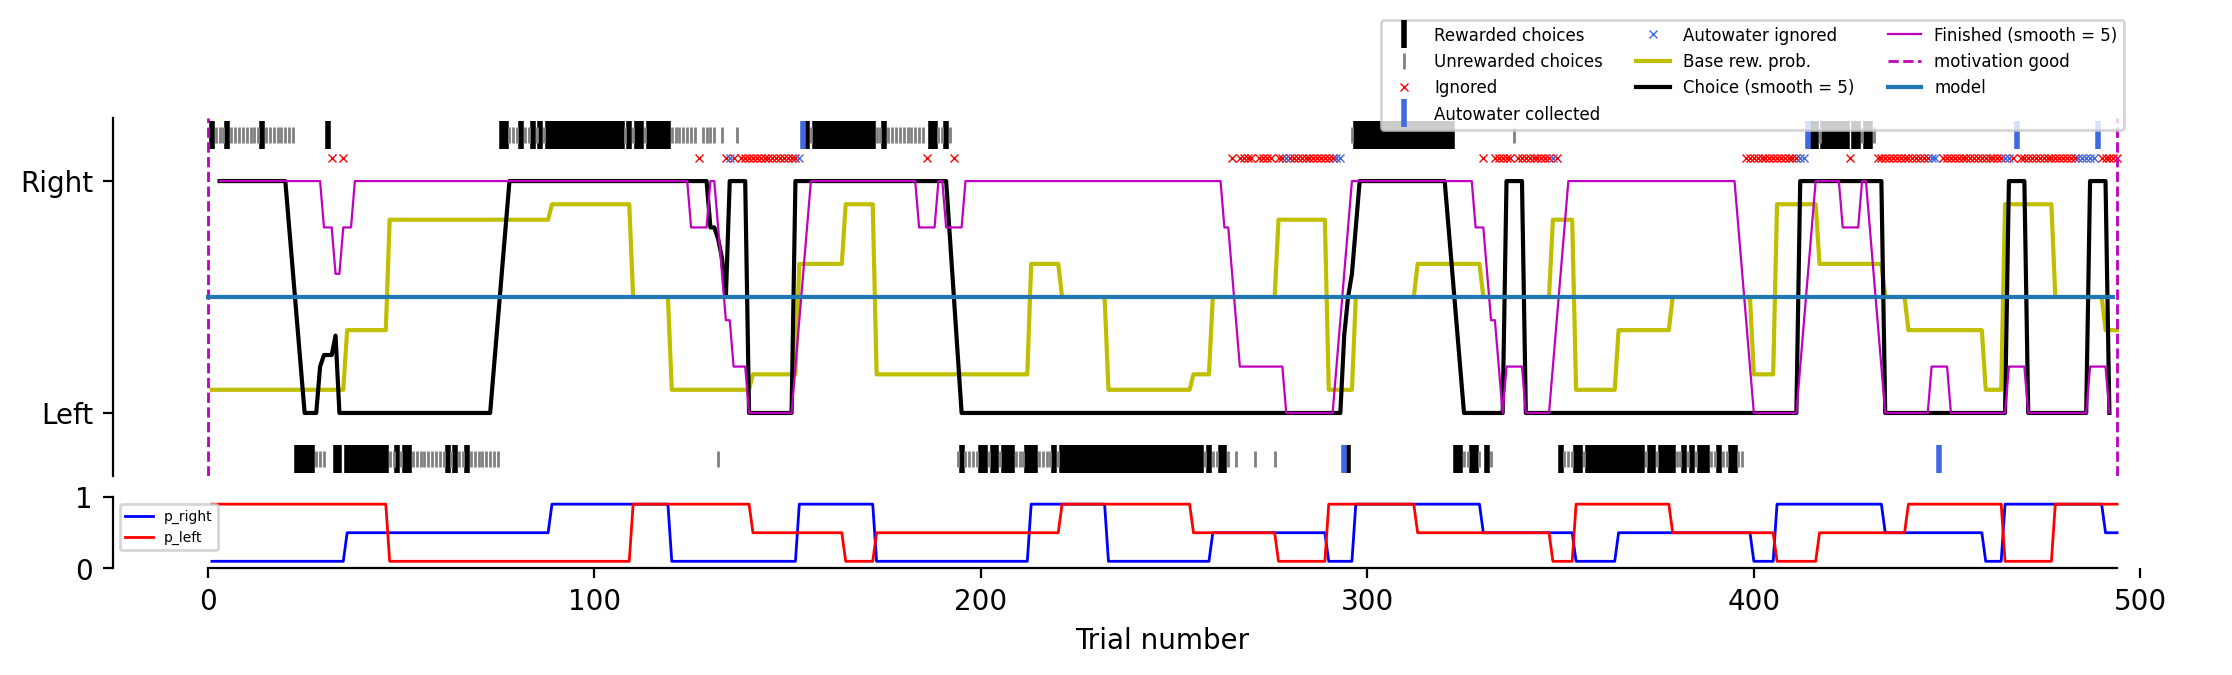

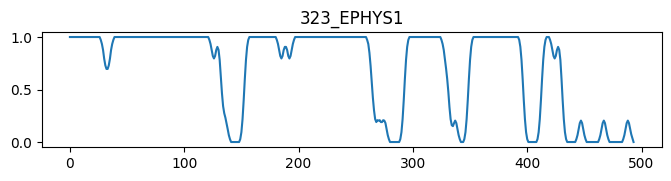

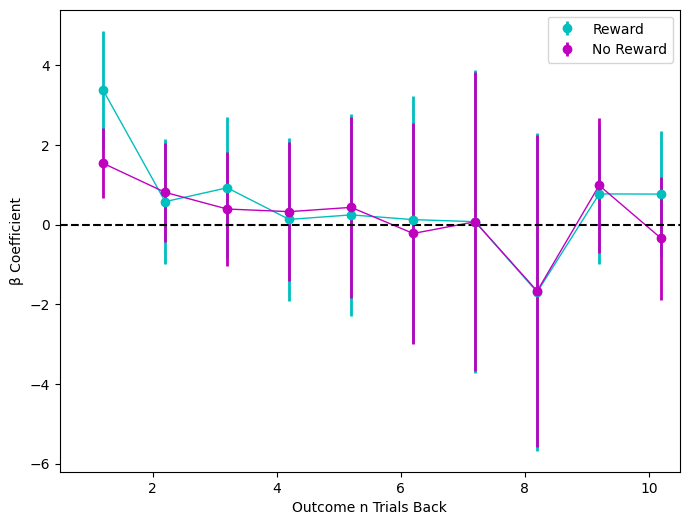

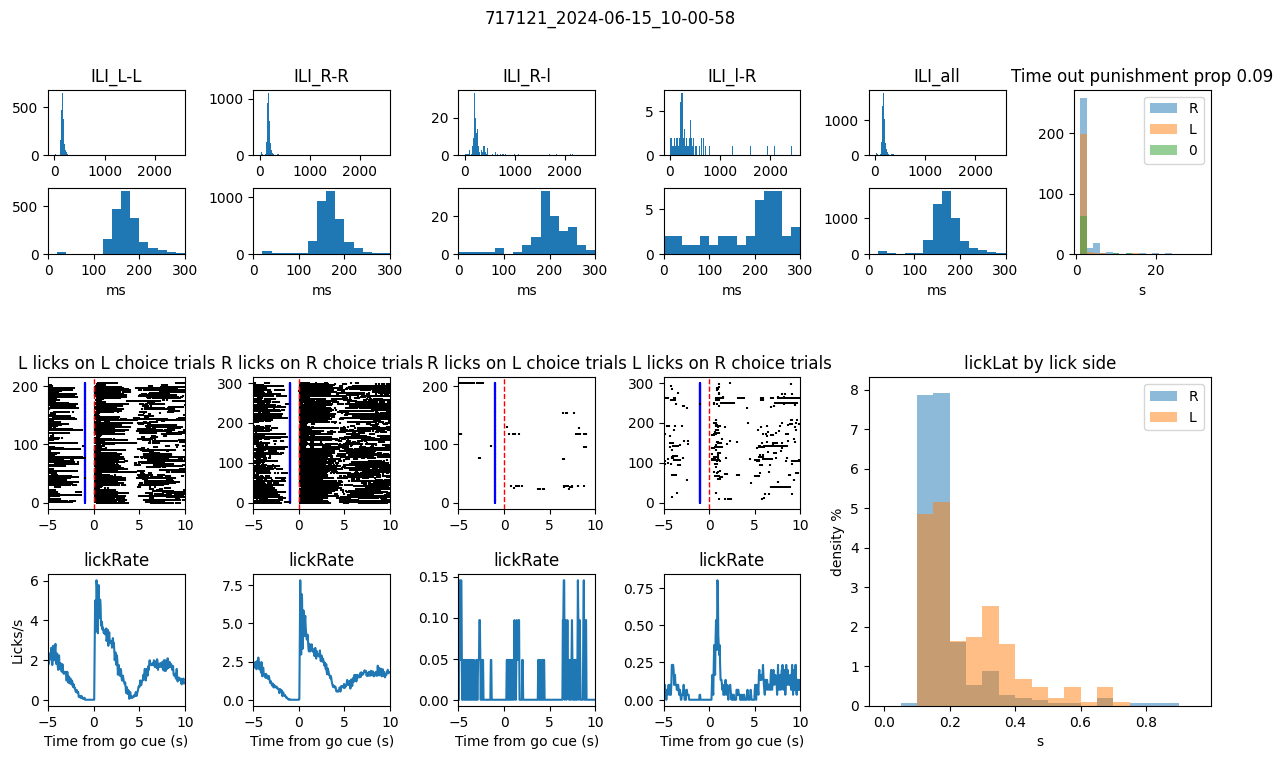

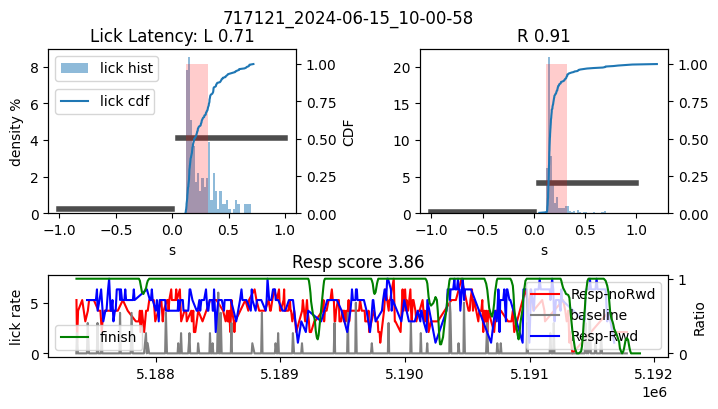

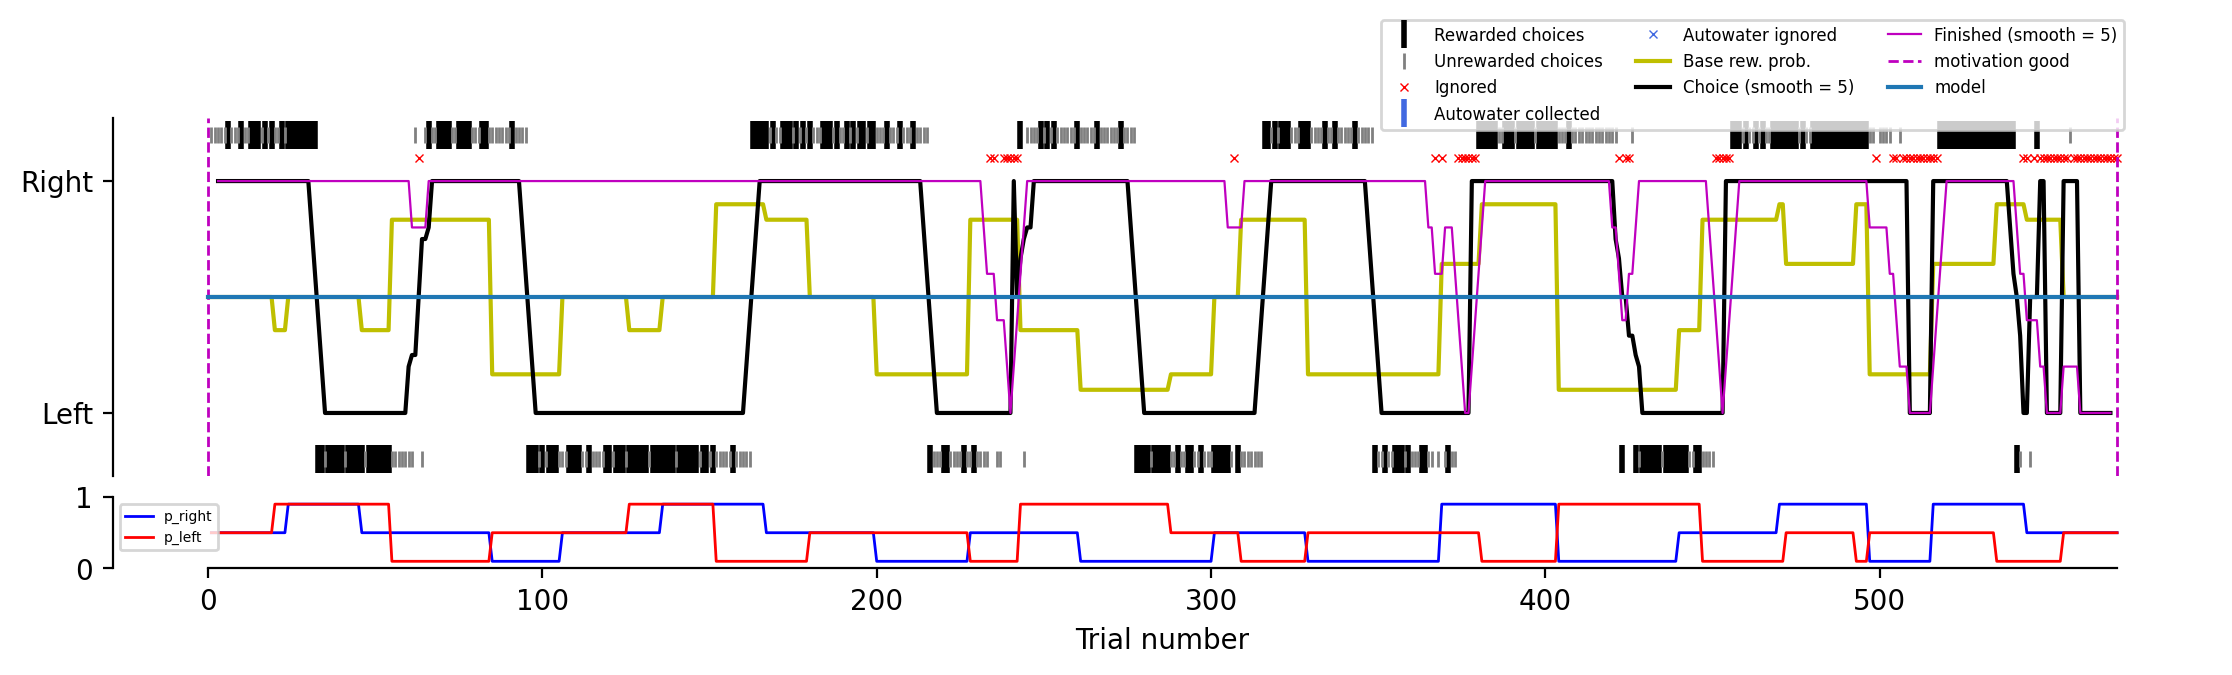

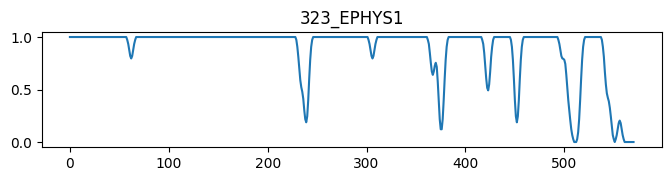

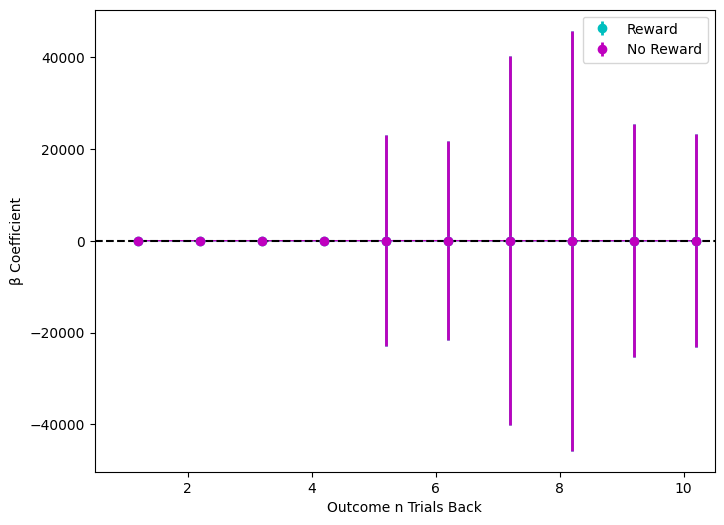

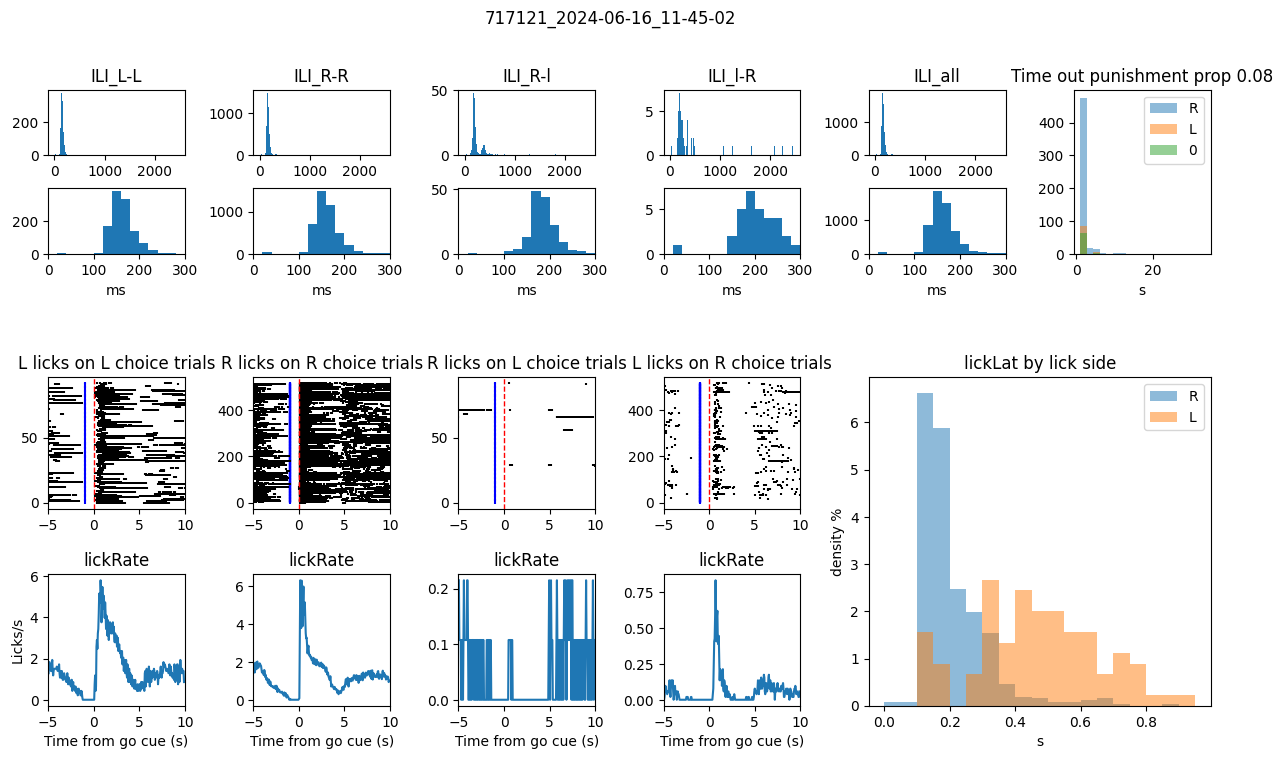

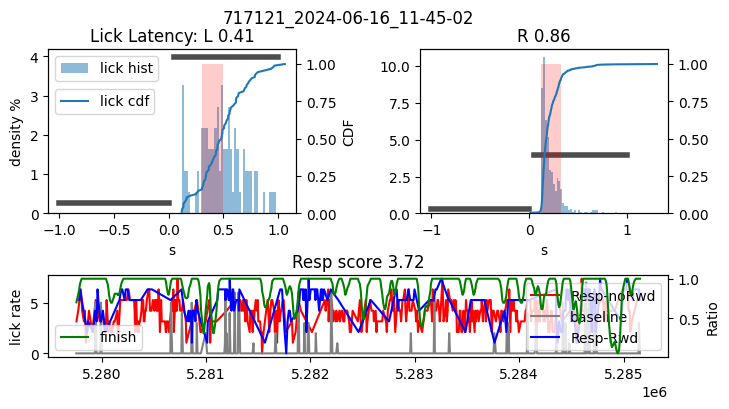

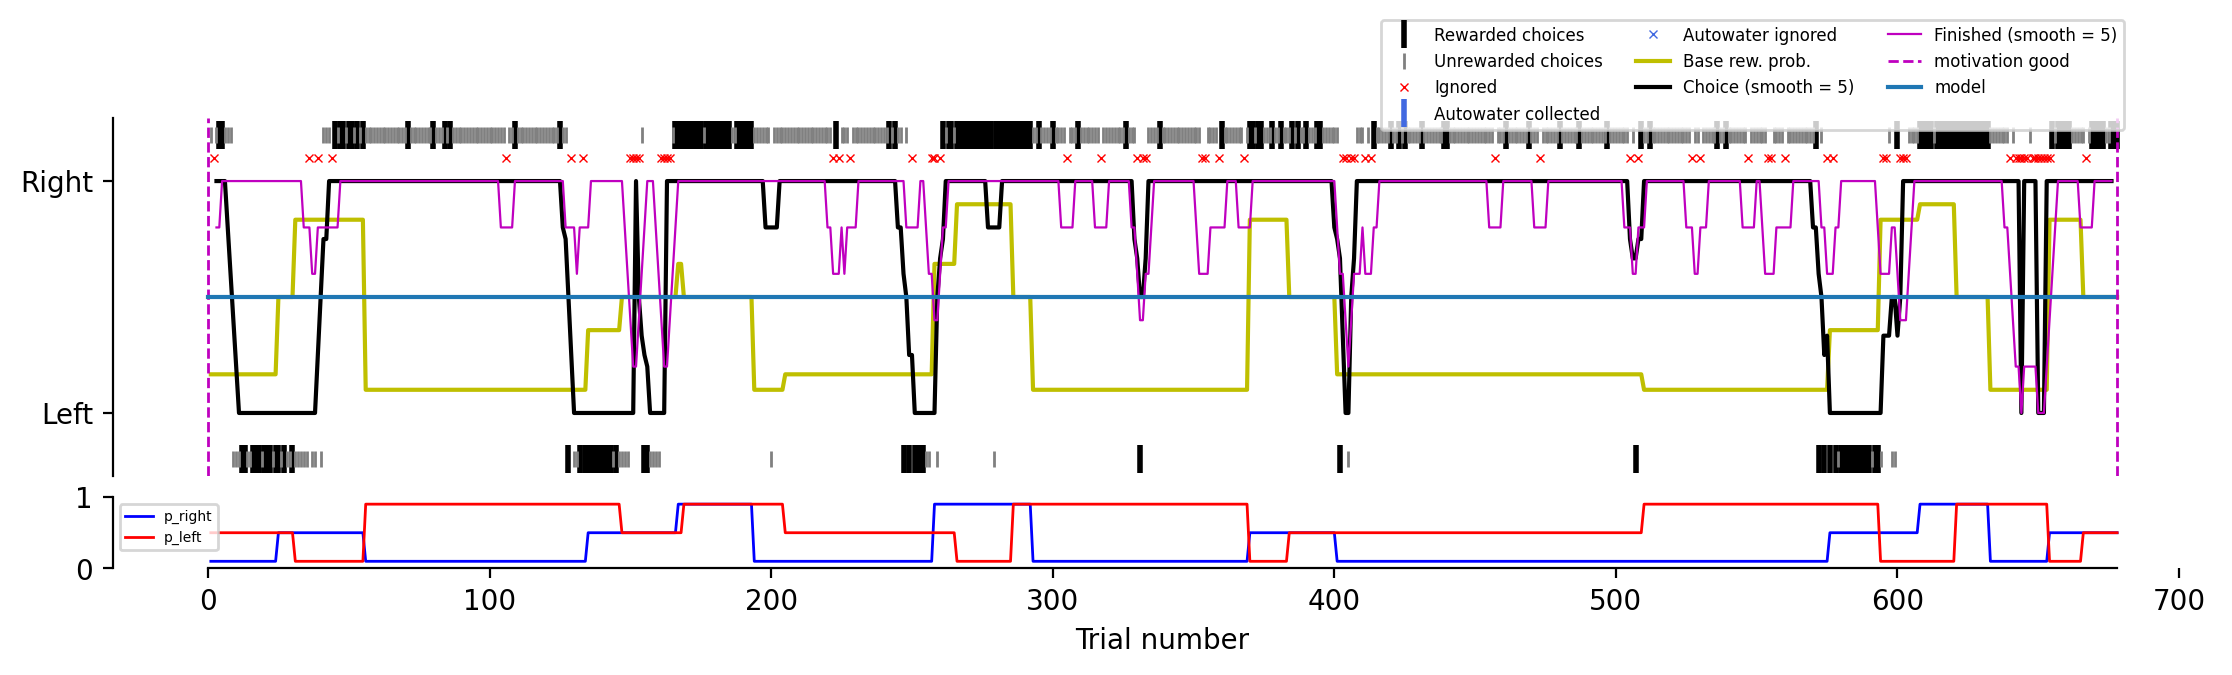

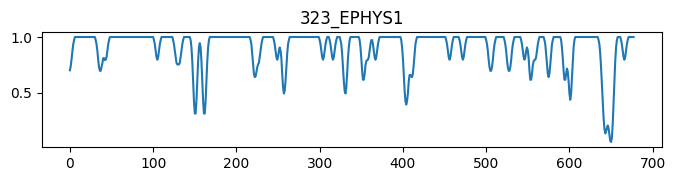

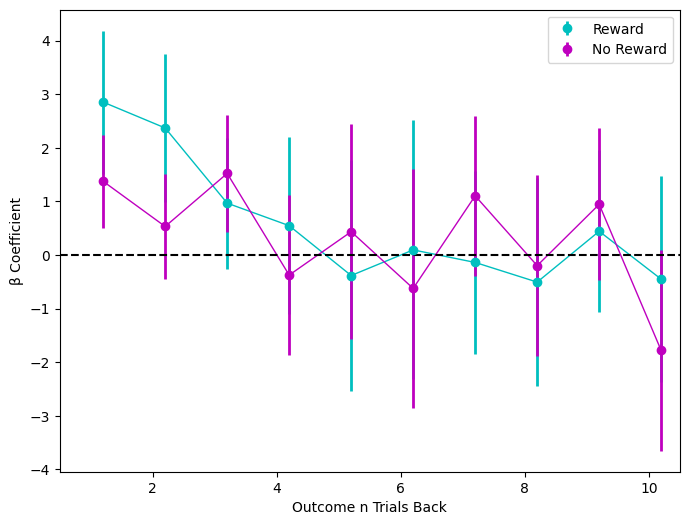

In [4]:
plt.close('all')
animal_dir = f'/root/capsule/scratch/{animalID}'
os.makedirs(animal_dir, exist_ok=True)
ani_session_data = {'session_id': [], 'session_cut': [], 'box': []}
ani_session_file = f'/root/capsule/scratch/{animalID}/{animalID}_session_data.csv'
for targetInd in targetInds:
    nwb_name = sessionInfo['sessionID'][targetInd]
    # load nwb file and data
    nwb_file = os.path.join(nwb_folder, nwb_name)
    nwb = load_nwb(nwb_file)
    if '323' in nwb.scratch['metadata'][0].box.values[0]:
        data = load_data(nwb)
        (
            _,
            choice_history,
            reward_history,
            p_reward,
            autowater_offered,
            _,
        ) = get_history_from_nwb(nwb)
        # plot
        fig, session_id = plot_lick_analysis(nwb)
        ani_session_data['session_id'].append(session_id)
        ani_session_data['box'].append(nwb.scratch['metadata'][0].box.values[0])
        ani_session_data['session_cut'].append([0, len(data['tbl_trials'])])
        lick_met = cal_metrics(data)
        fig, _ = plot_met(data, lick_met)
        fitted_data = np.ones(len(choice_history)) * 0.5
        valid_range = [0, len(choice_history)]
        fig, _ = plot_foraging_session(
                choice_history=list(choice_history),
                reward_history=list(reward_history),
                p_reward=p_reward,
                autowater_offered=autowater_offered,
                fitted_data=fitted_data,
                valid_range=valid_range,
                smooth_factor=5,
                base_color="y",
                ax=None,
                vertical=False,
            )
        fig = plt.figure(figsize=(8, 1.5))
        plt.plot(lick_met['finish_ratio'])
        plt.title(nwb.scratch['metadata'][0].box.values[0])
        plot_session_glm(nwb)


ani_session_dataframe = pd.DataFrame(ani_session_data)
ani_session_dataframe.to_csv(ani_session_file, index=False)

print(f"Dictionary has been saved to {ani_session_file}")
    
    